In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import label_binarize


In [2]:
pd.set_option('display.max_rows', None)

In [3]:
from sklearn.neural_network import MLPClassifier

param_dist_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'solver': ['adam'],
    'max_iter': [200, 300]
}


In [4]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize


def train_phase(phase_path, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_params = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        if fold == 1:
            clf = MLPClassifier(random_state=random_state)
            search = RandomizedSearchCV(
                clf,
                param_distributions=param_dist_mlp,
                n_iter=n_iter,
                cv=3,
                n_jobs=-1,
                verbose=1,
                scoring='f1_macro'
            )
            search.fit(X_train_scaled, y_train)
            best_params = search.best_params_
            print(f"[Fold 1] Best Parameters Found: {best_params}")

        model = MLPClassifier(**best_params, random_state=random_state)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        y_proba = model.predict_proba(X_val_scaled)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        classes = model.classes_
        y_val_bin = label_binarize(y_val, classes=classes)
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    return best_model, best_scaler, best_fold, all_metrics




======= Training Phase 1 ========

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'logistic'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.92      0.82      1785
           1       0.53      0.25      0.34       604
           2       0.46      0.29      0.36       258
           3       0.35      0.19      0.24        59
           4       0.17      0.11      0.13         9

    accuracy                           0.69      2715
   macro avg       0.45      0.35      0.38      2715
weighted avg       0.66      0.69      0.66      2715



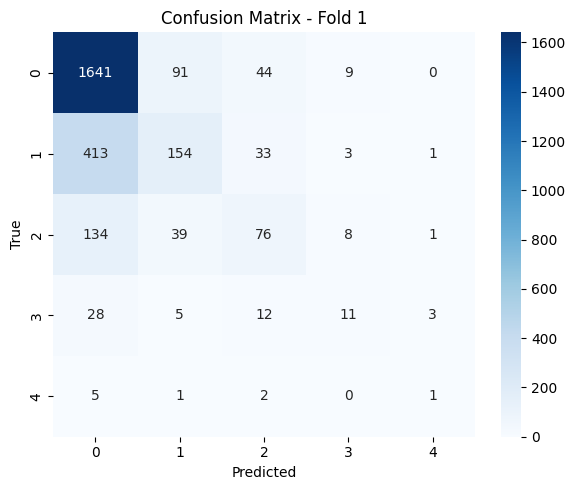

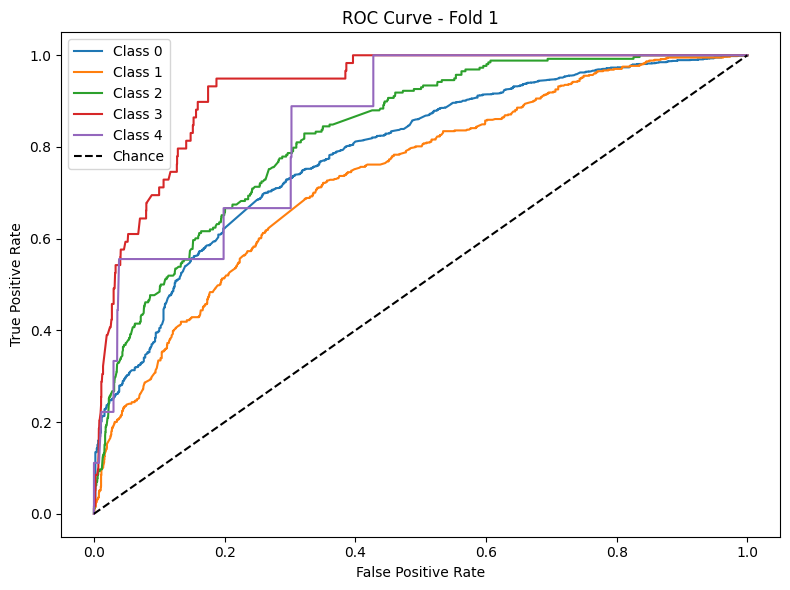


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.89      0.82      1786
           1       0.50      0.29      0.36       603
           2       0.41      0.36      0.38       258
           3       0.26      0.15      0.19        59
           4       0.00      0.00      0.00         8

    accuracy                           0.69      2714
   macro avg       0.39      0.34      0.35      2714
weighted avg       0.65      0.69      0.66      2714



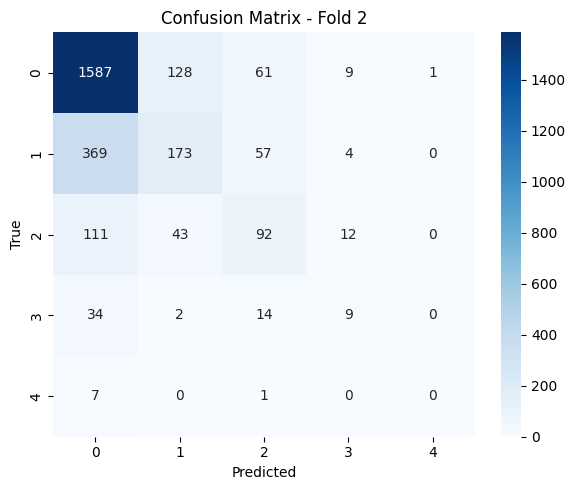

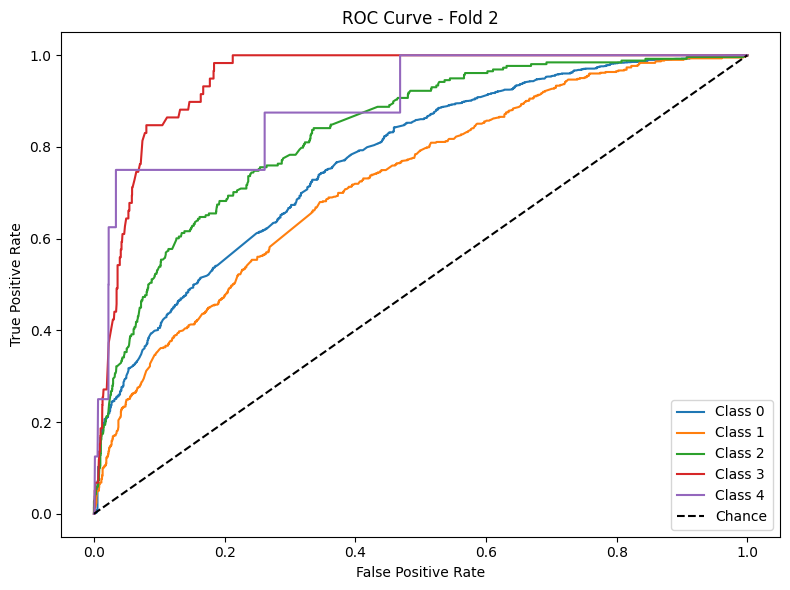


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.91      0.82      1786
           1       0.55      0.29      0.38       603
           2       0.41      0.30      0.35       258
           3       0.45      0.32      0.38        59
           4       0.14      0.12      0.13         8

    accuracy                           0.70      2714
   macro avg       0.46      0.39      0.41      2714
weighted avg       0.66      0.70      0.67      2714



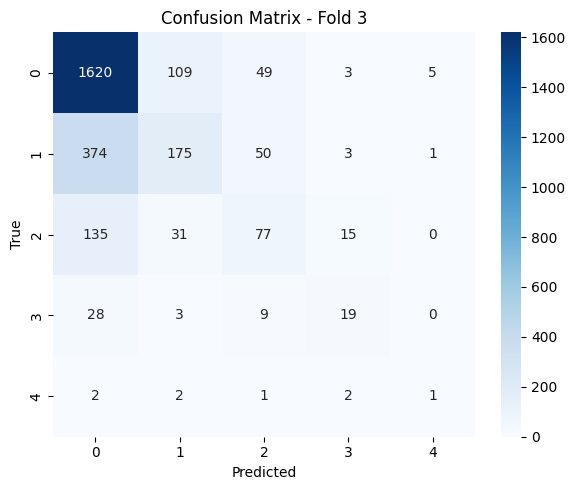

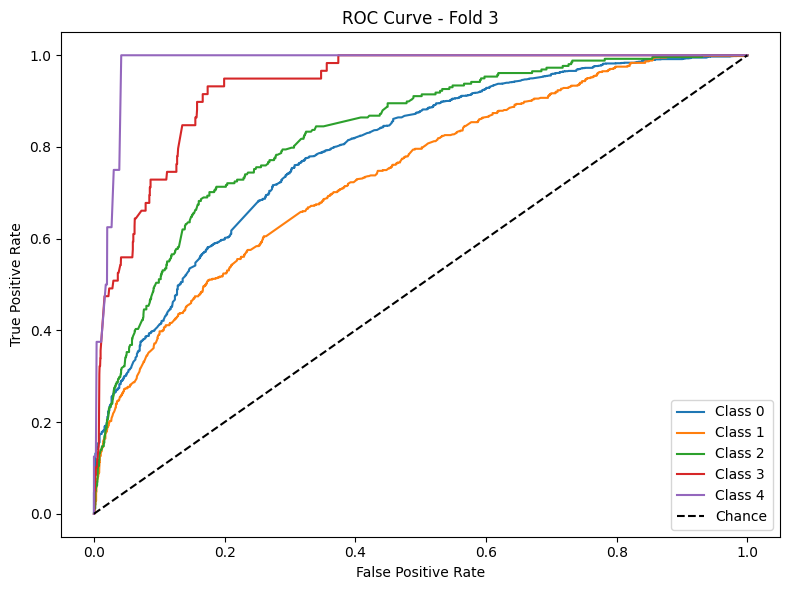


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83      1785
           1       0.57      0.34      0.42       603
           2       0.47      0.37      0.41       258
           3       0.43      0.20      0.28        59
           4       0.00      0.00      0.00         9

    accuracy                           0.71      2714
   macro avg       0.45      0.36      0.39      2714
weighted avg       0.68      0.71      0.68      2714



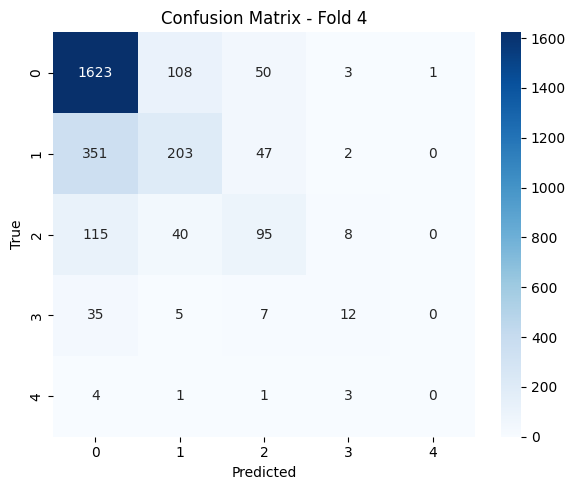

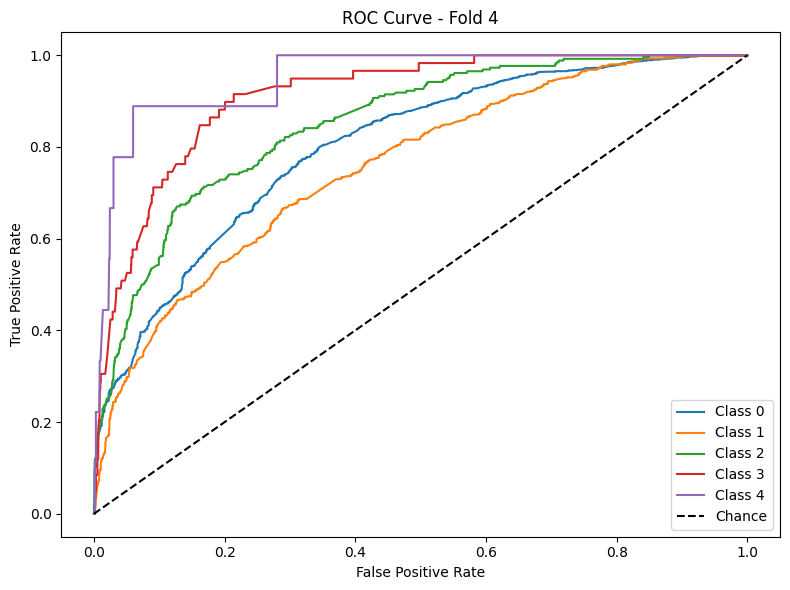


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.92      0.83      1785
           1       0.58      0.29      0.39       603
           2       0.46      0.36      0.40       258
           3       0.27      0.07      0.11        59
           4       0.00      0.00      0.00         9

    accuracy                           0.71      2714
   macro avg       0.41      0.33      0.35      2714
weighted avg       0.67      0.71      0.67      2714



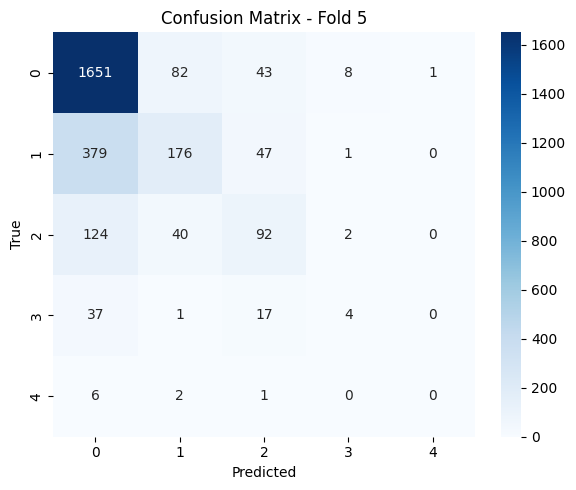

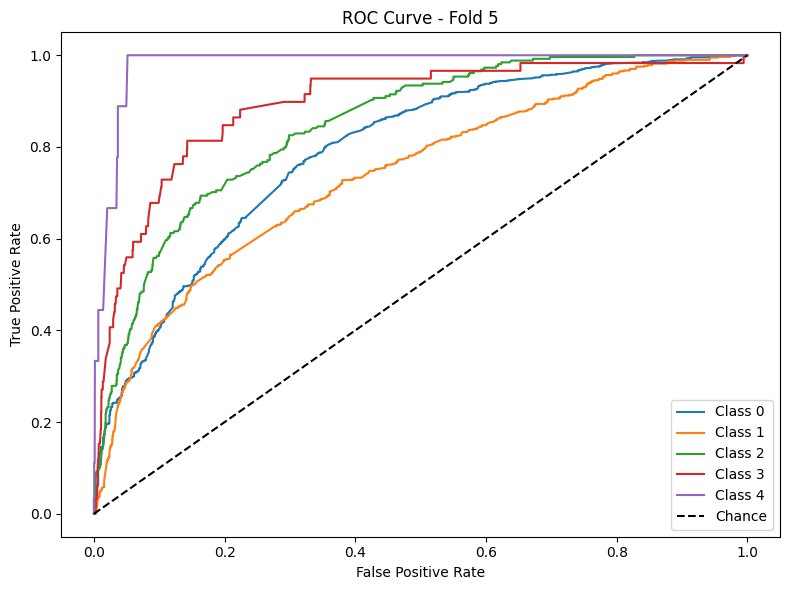


Average Accuracy: 0.6994
Average F1 Macro: 0.3753
Average AUC: 0.8441


======= Training Phase 2 ========

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (50,), 'alpha': 0.0001, 'activation': 'relu'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.95      0.82      1489
           1       0.61      0.19      0.29       488
           2       0.48      0.25      0.33       220
           3       0.38      0.19      0.25        54
           4       0.00      0.00      0.00         9

    accuracy                           0.70      2260
   macro avg       0.44      0.31      0.34      2260
weighted avg       0.66      0.70      0.64      2260



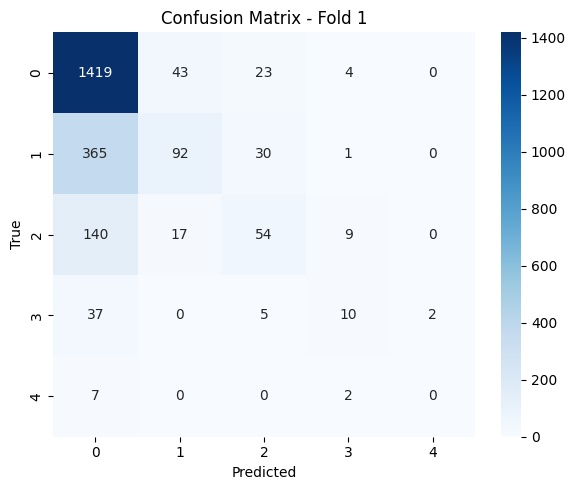

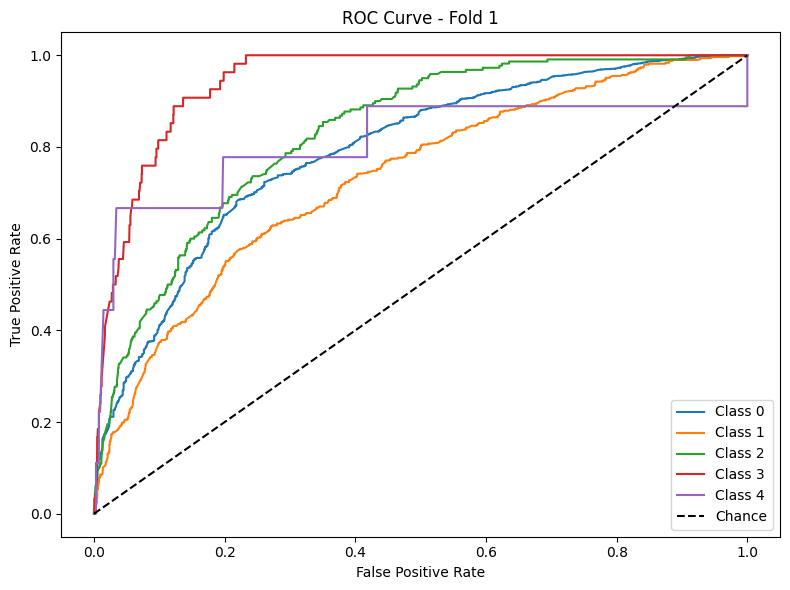


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.90      0.82      1489
           1       0.53      0.32      0.40       489
           2       0.47      0.37      0.41       219
           3       0.00      0.00      0.00        55
           4       1.00      0.12      0.22         8

    accuracy                           0.70      2260
   macro avg       0.55      0.34      0.37      2260
weighted avg       0.66      0.70      0.66      2260



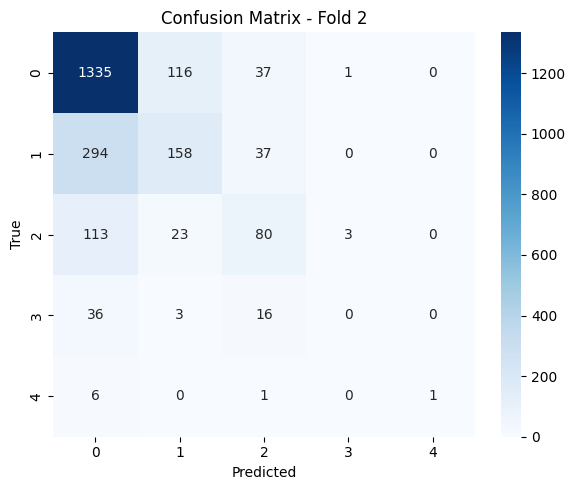

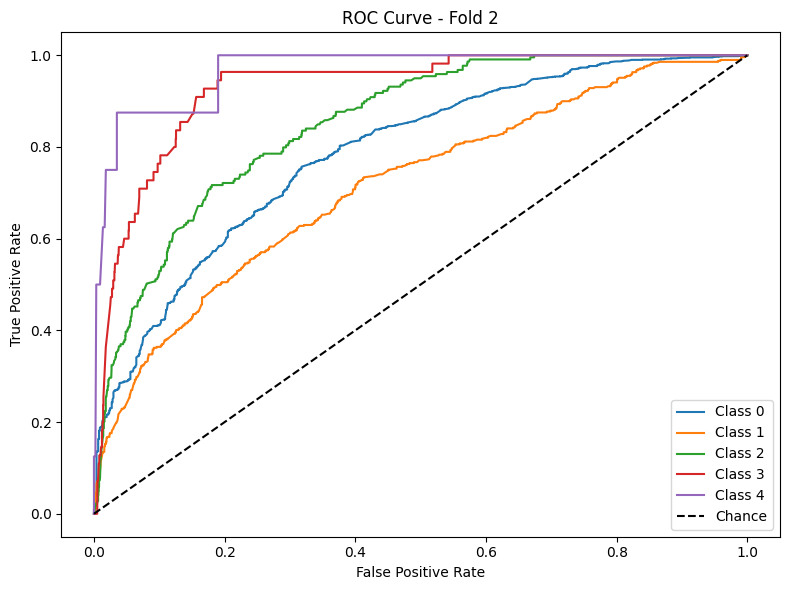


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.93      0.82      1489
           1       0.46      0.20      0.28       489
           2       0.55      0.23      0.32       219
           3       0.24      0.26      0.25        54
           4       0.00      0.00      0.00         8

    accuracy                           0.69      2259
   macro avg       0.40      0.32      0.34      2259
weighted avg       0.64      0.69      0.64      2259



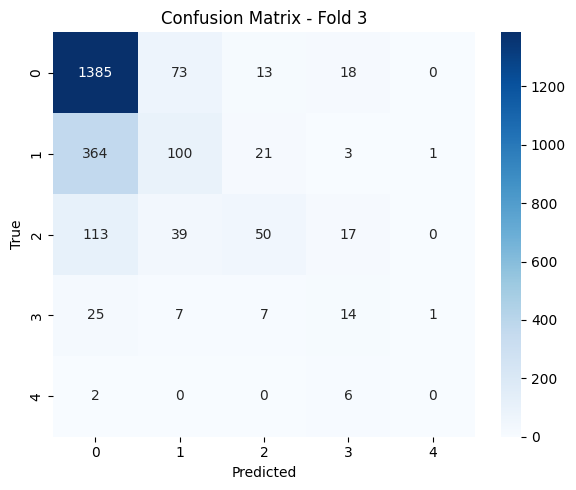

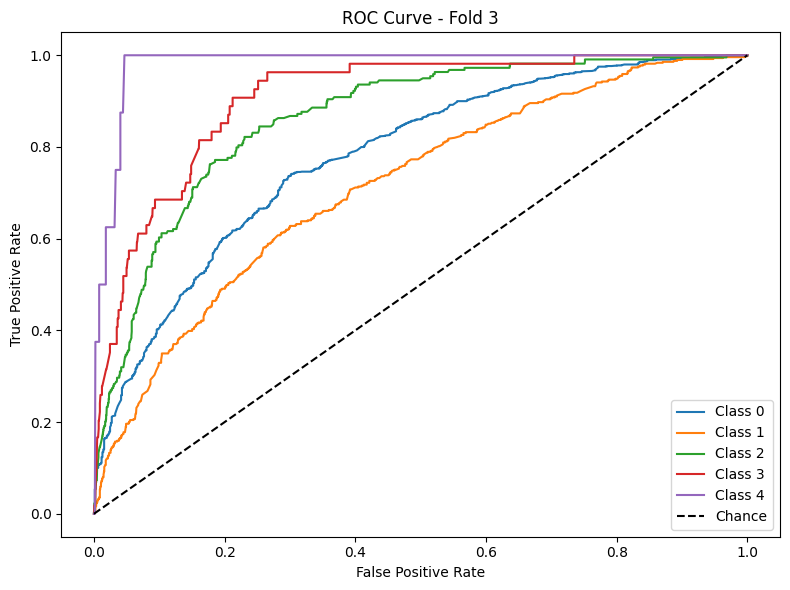


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.95      0.82      1489
           1       0.65      0.19      0.30       489
           2       0.45      0.29      0.35       219
           3       0.00      0.00      0.00        54
           4       1.00      0.25      0.40         8

    accuracy                           0.70      2259
   macro avg       0.56      0.34      0.37      2259
weighted avg       0.66      0.70      0.64      2259



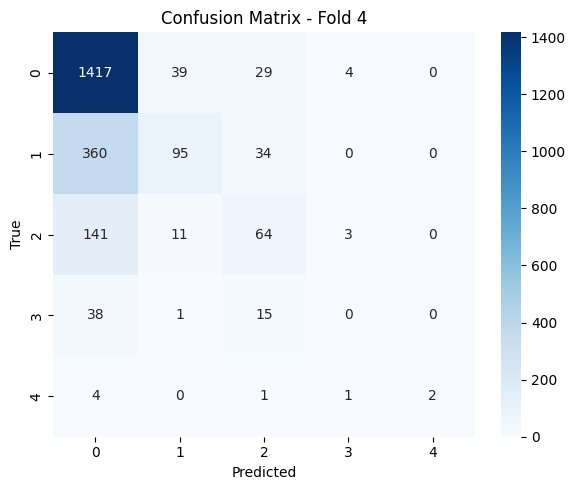

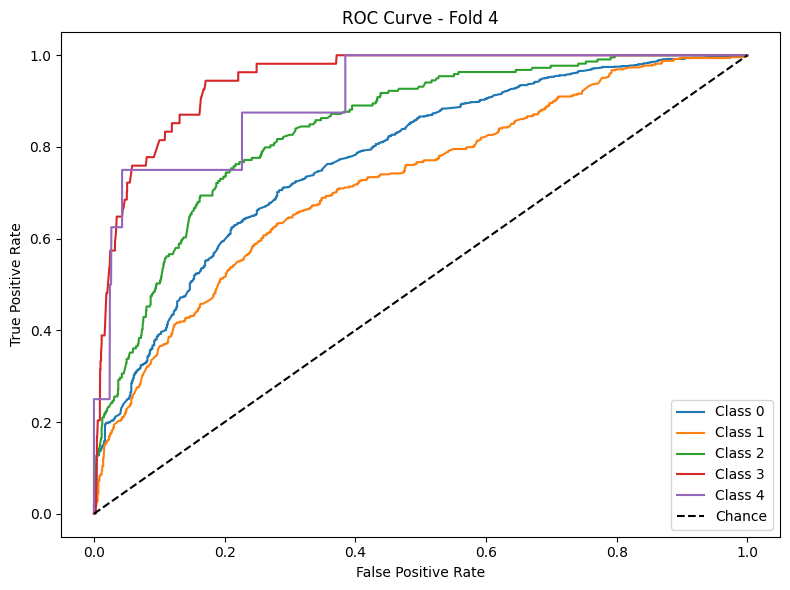


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.82      1490
           1       0.50      0.36      0.42       488
           2       0.46      0.33      0.38       219
           3       0.20      0.04      0.06        54
           4       1.00      0.12      0.22         8

    accuracy                           0.69      2259
   macro avg       0.58      0.35      0.38      2259
weighted avg       0.66      0.69      0.67      2259



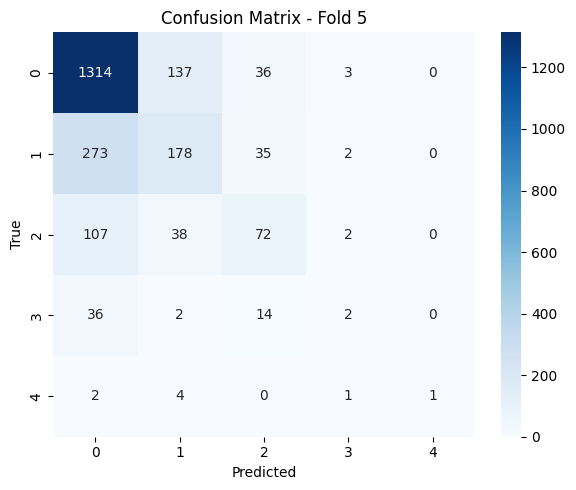

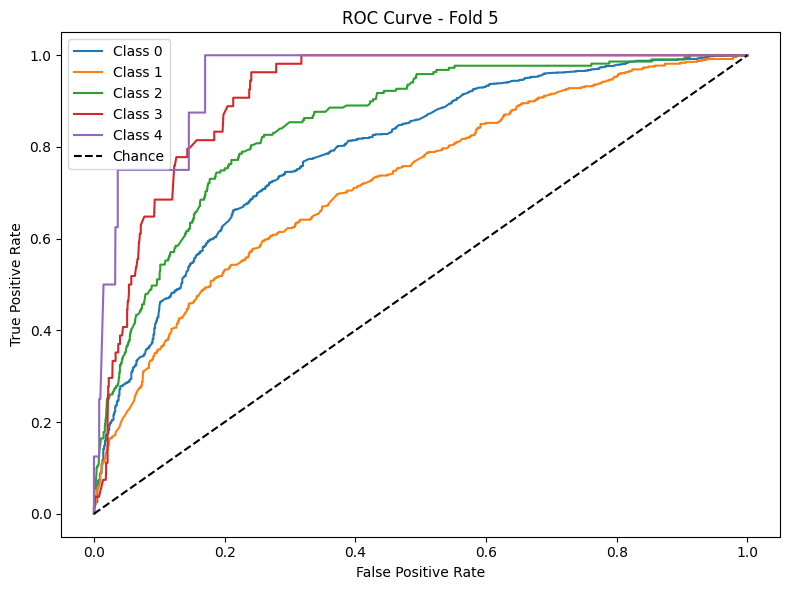


Average Accuracy: 0.6943
Average F1 Macro: 0.3594
Average AUC: 0.8410


======= Training Phase 3 ========

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 200, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'tanh'}


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and 


Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.91      0.82      1361
           1       0.49      0.19      0.28       459
           2       0.39      0.38      0.39       198
           3       0.21      0.12      0.16        49
           4       0.00      0.00      0.00         7

    accuracy                           0.68      2074
   macro avg       0.37      0.32      0.33      2074
weighted avg       0.64      0.68      0.64      2074



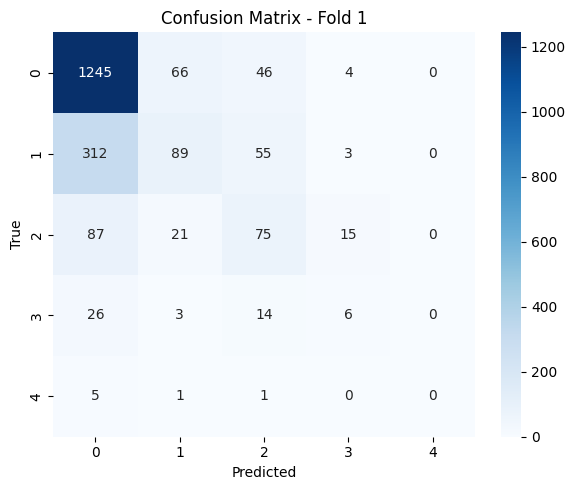

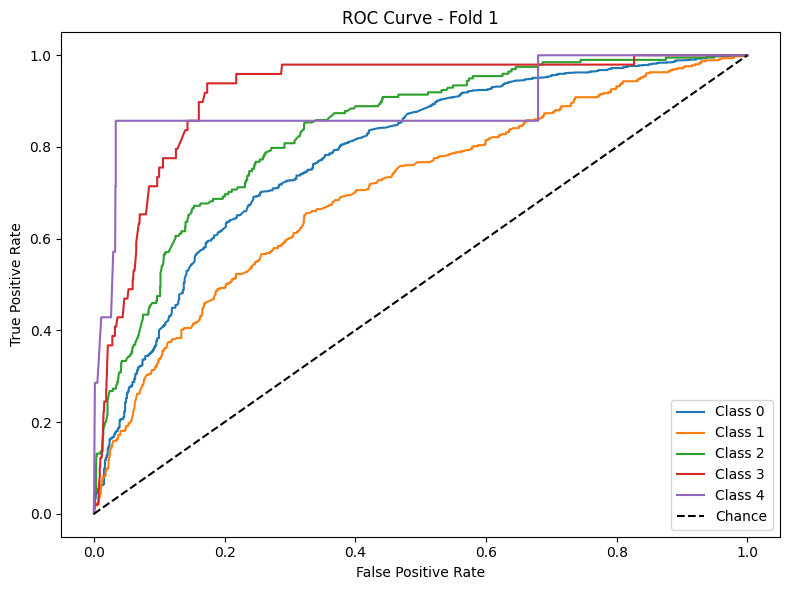

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.90      0.81      1360
           1       0.51      0.24      0.32       459
           2       0.46      0.37      0.41       198
           3       0.39      0.26      0.31        50
           4       0.50      0.14      0.22         7

    accuracy                           0.69      2074
   macro avg       0.52      0.38      0.42      2074
weighted avg       0.65      0.69      0.65      2074



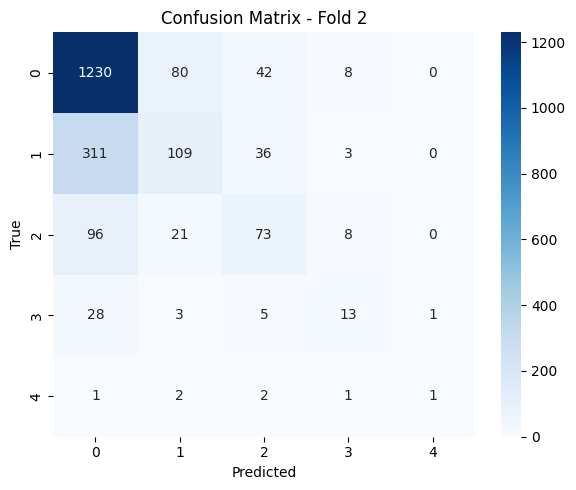

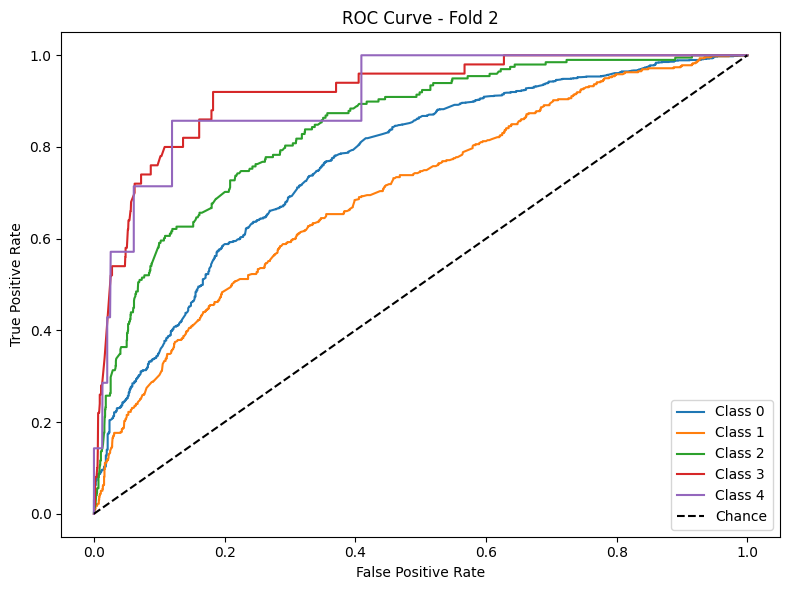

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.87      0.82      1360
           1       0.46      0.33      0.38       459
           2       0.44      0.43      0.44       198
           3       0.53      0.16      0.25        50
           4       0.50      0.14      0.22         7

    accuracy                           0.69      2074
   macro avg       0.54      0.39      0.42      2074
weighted avg       0.66      0.69      0.67      2074



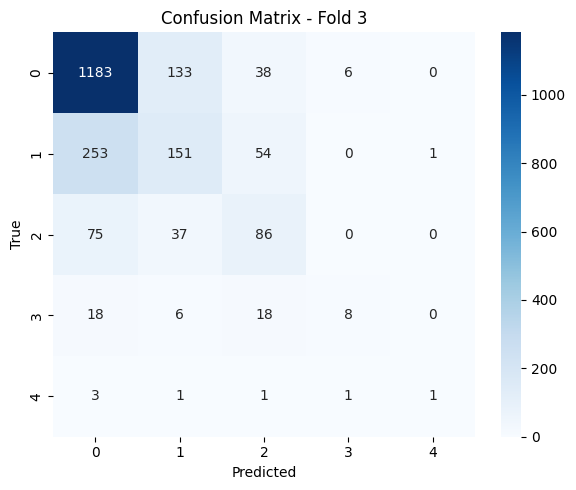

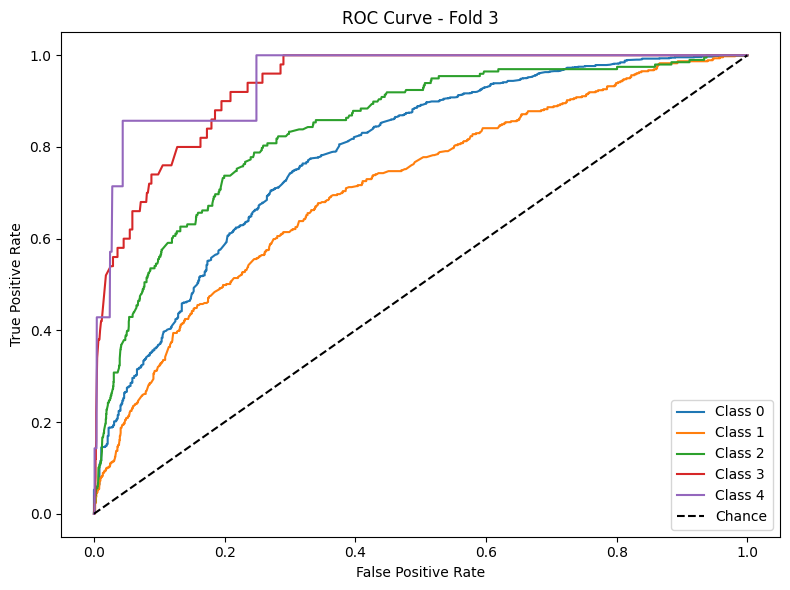

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.89      0.80      1360
           1       0.39      0.23      0.29       459
           2       0.45      0.31      0.37       198
           3       0.40      0.12      0.18        50
           4       0.00      0.00      0.00         7

    accuracy                           0.66      2074
   macro avg       0.39      0.31      0.33      2074
weighted avg       0.62      0.66      0.63      2074



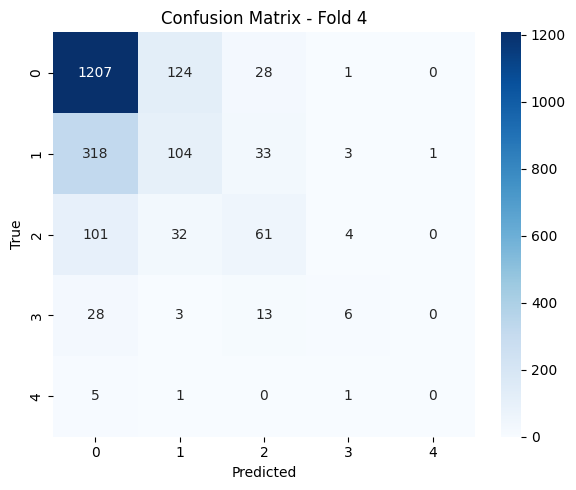

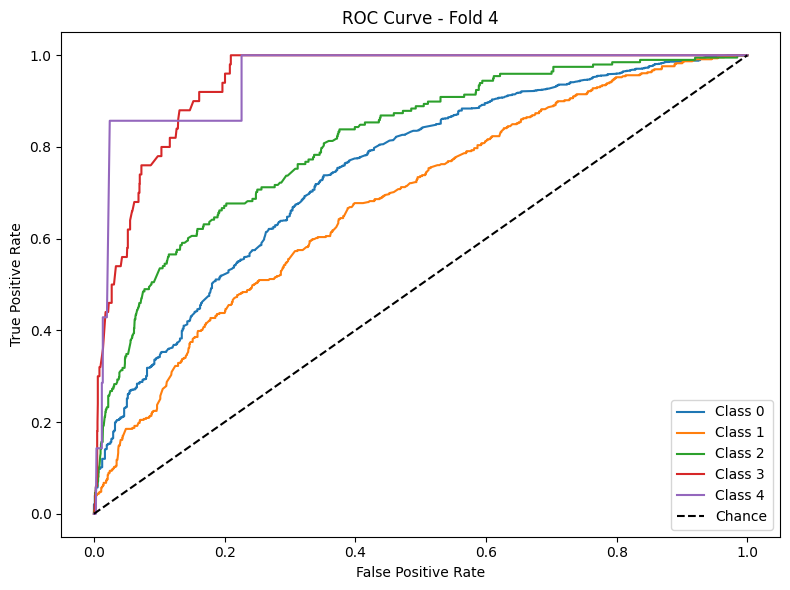

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.89      0.81      1360
           1       0.44      0.21      0.29       460
           2       0.41      0.39      0.40       197
           3       0.39      0.29      0.33        49
           4       0.00      0.00      0.00         7

    accuracy                           0.68      2073
   macro avg       0.40      0.36      0.37      2073
weighted avg       0.64      0.68      0.64      2073



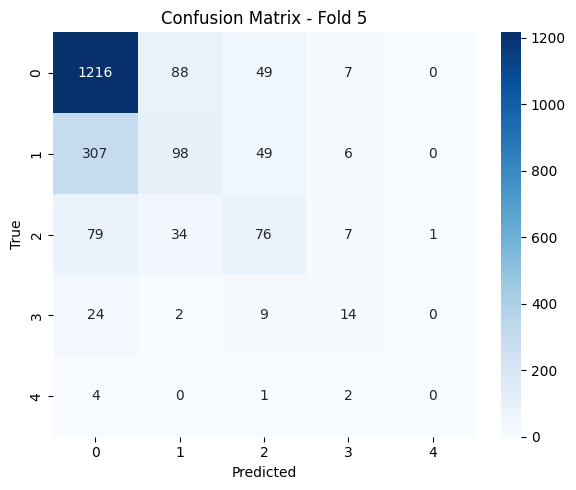

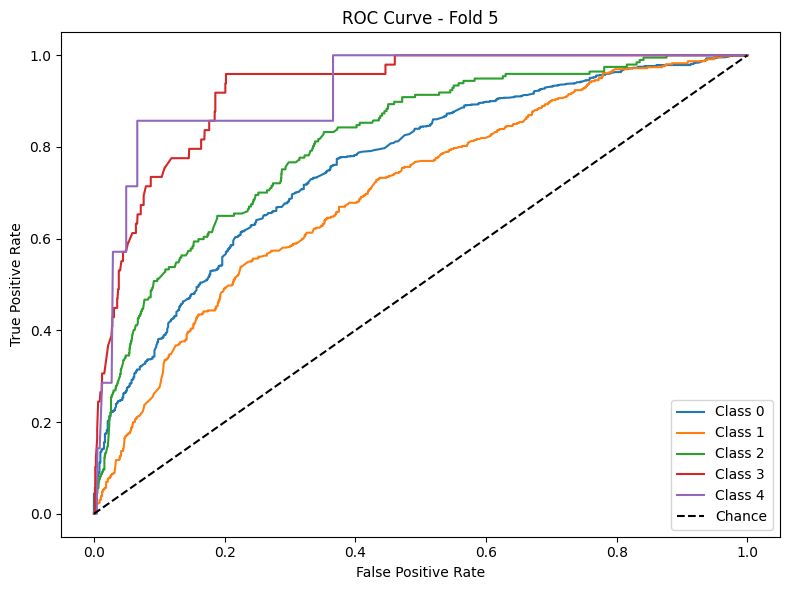


Average Accuracy: 0.6801
Average F1 Macro: 0.3718
Average AUC: 0.8300


======= Training Phase 4 ========

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 200, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 50), 'alpha': 0.01, 'activation': 'tanh'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.81      1000
           1       0.50      0.31      0.39       355
           2       0.40      0.37      0.39       139
           3       0.26      0.21      0.23        39
           4       0.00      0.00      0.00         6

    accuracy                           0.68      1539
   macro avg       0.38      0.35      0.36      1539
weighted avg       0.65      0.68      0.66      1539



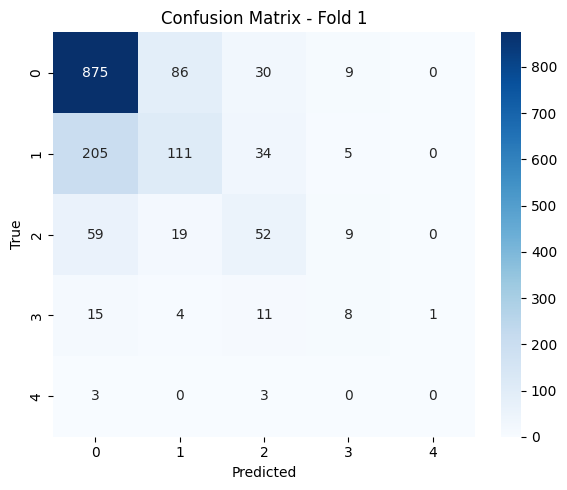

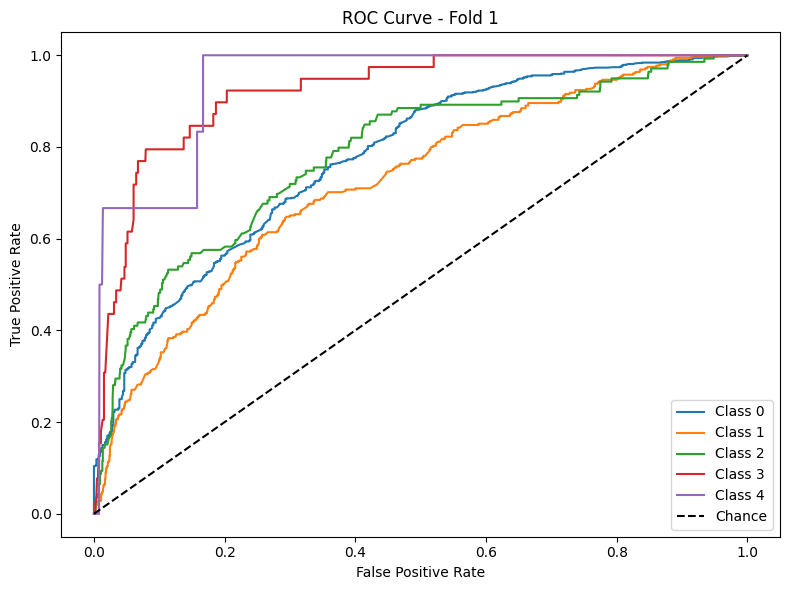

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.91      0.82      1000
           1       0.55      0.28      0.38       355
           2       0.47      0.43      0.45       139
           3       0.45      0.12      0.20        40
           4       0.00      0.00      0.00         5

    accuracy                           0.70      1539
   macro avg       0.44      0.35      0.37      1539
weighted avg       0.66      0.70      0.66      1539



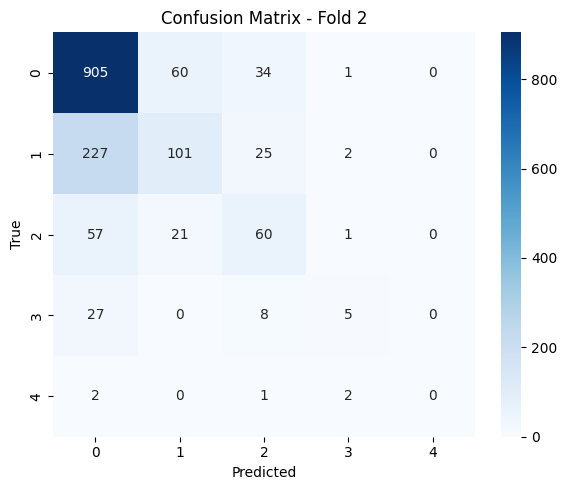

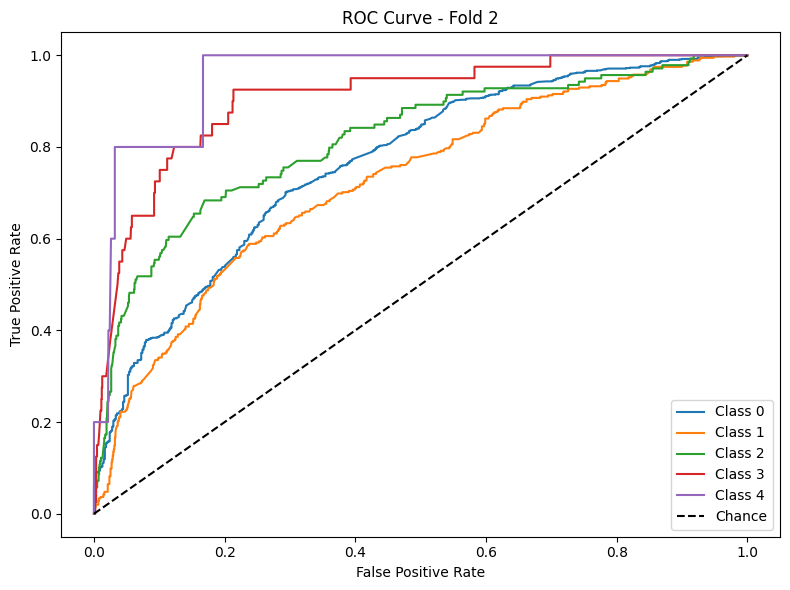


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.87      0.82       999
           1       0.53      0.44      0.48       355
           2       0.53      0.36      0.43       139
           3       0.46      0.28      0.34        40
           4       1.00      0.17      0.29         6

    accuracy                           0.71      1539
   macro avg       0.66      0.42      0.47      1539
weighted avg       0.69      0.71      0.69      1539



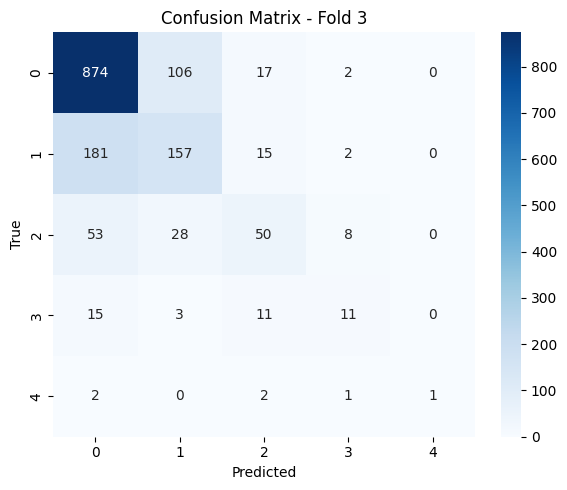

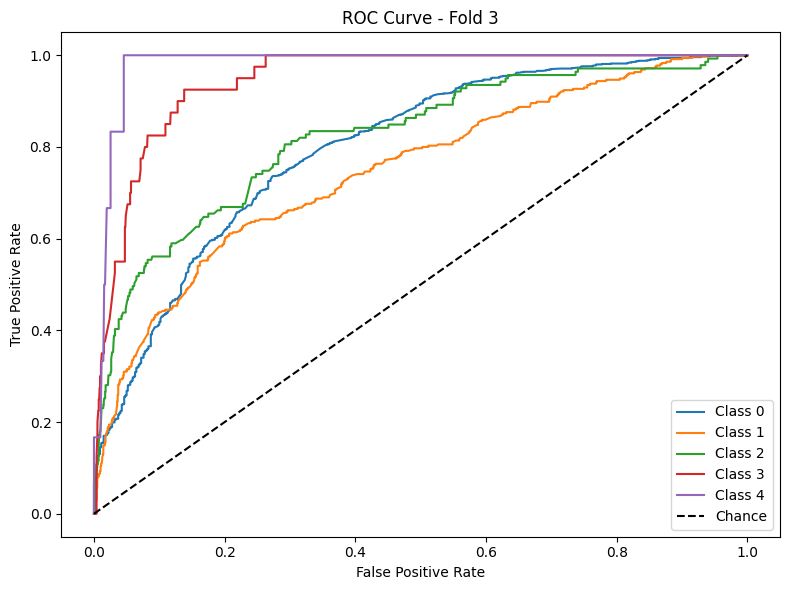


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83       999
           1       0.50      0.29      0.37       356
           2       0.40      0.33      0.36       138
           3       0.25      0.21      0.23        39
           4       0.00      0.00      0.00         6

    accuracy                           0.69      1538
   macro avg       0.38      0.35      0.36      1538
weighted avg       0.65      0.69      0.66      1538



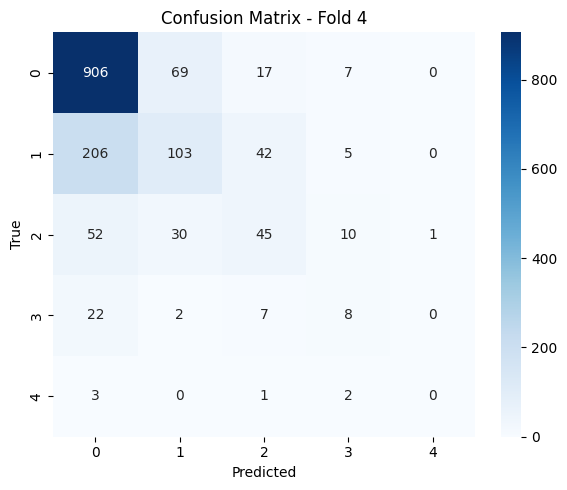

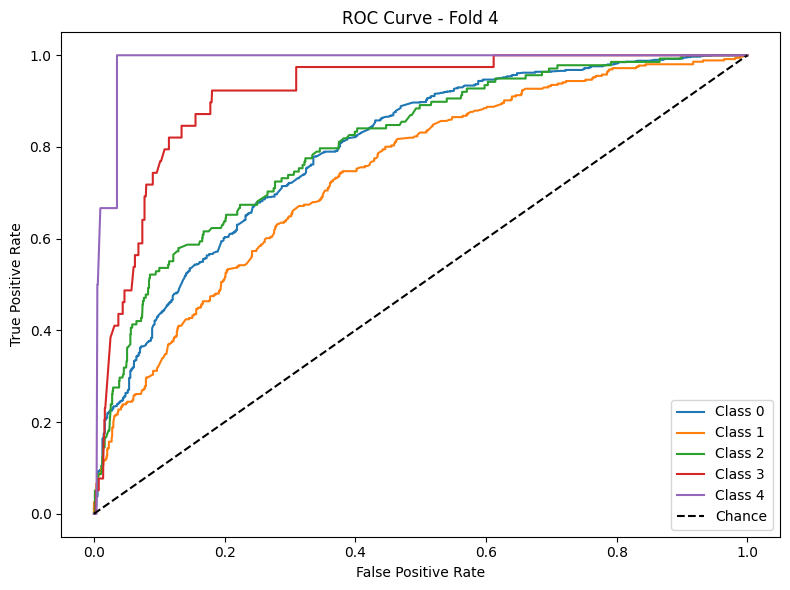

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.89      0.81       999
           1       0.51      0.31      0.39       356
           2       0.37      0.30      0.33       138
           3       0.44      0.18      0.25        39
           4       1.00      0.17      0.29         6

    accuracy                           0.68      1538
   macro avg       0.61      0.37      0.41      1538
weighted avg       0.65      0.68      0.66      1538



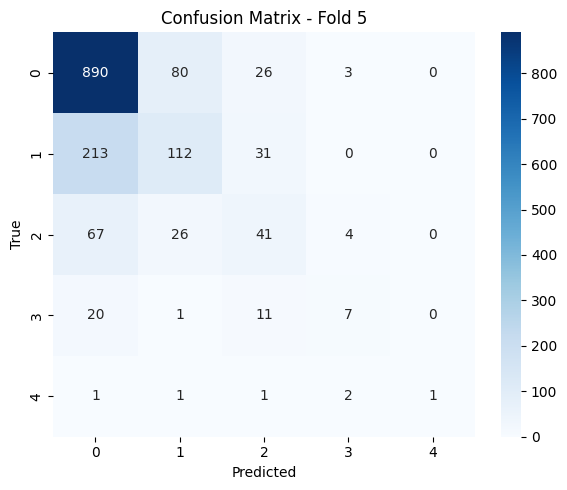

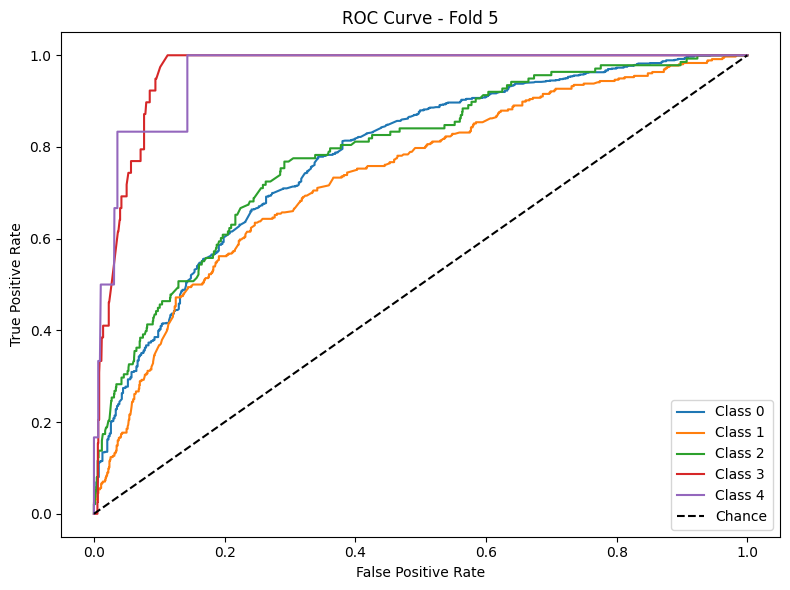


Average Accuracy: 0.6919
Average F1 Macro: 0.3947
Average AUC: 0.8430


In [5]:
phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


## Predict on Test Data

In [6]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    classes = model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred



Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       568
           1       0.21      0.22      0.22        63
           2       0.27      0.19      0.22        43
           3       0.00      0.00      0.00        15
           4       0.33      0.11      0.17         9

    accuracy                           0.79       698
   macro avg       0.34      0.29      0.30       698
weighted avg       0.76      0.79      0.77       698



/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


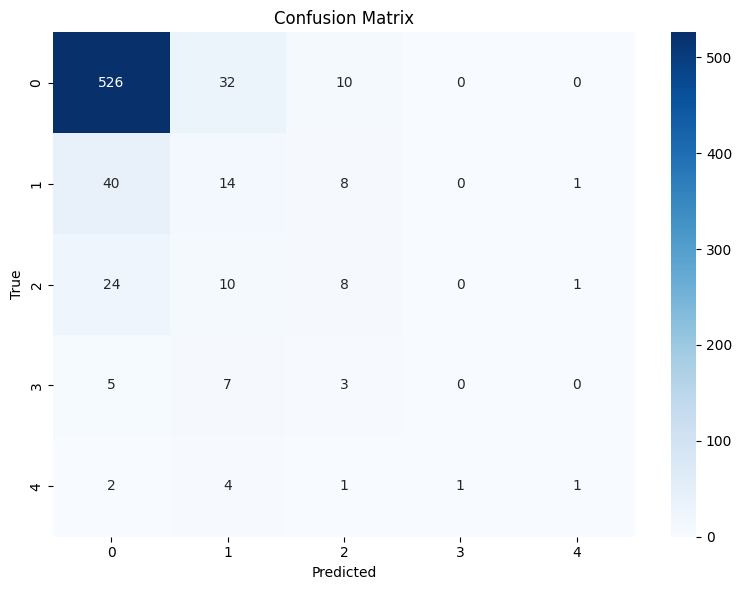


Test AUC (macro-average, OVR): 0.7057


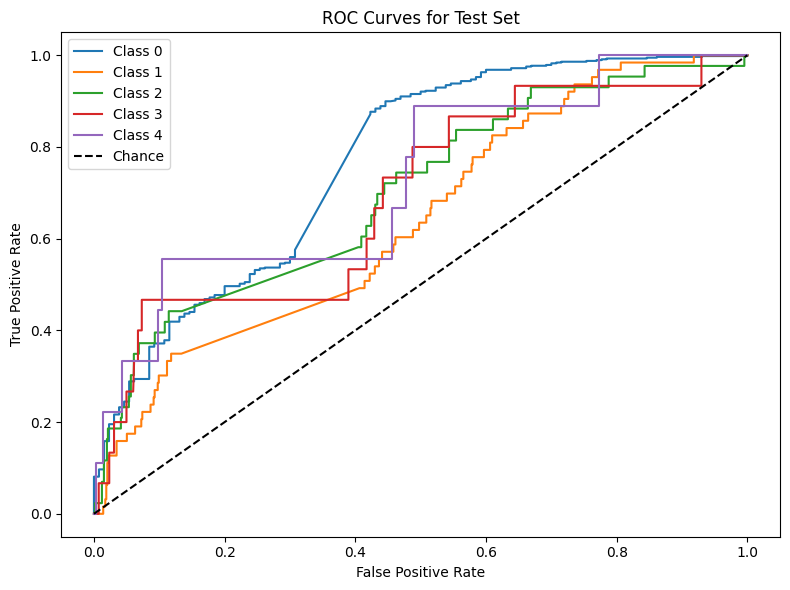

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       544
           1       0.18      0.37      0.25        59
           2       0.33      0.29      0.31        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.74       668
   macro avg       0.28      0.30      0.29       668
weighted avg       0.78      0.74      0.76       668



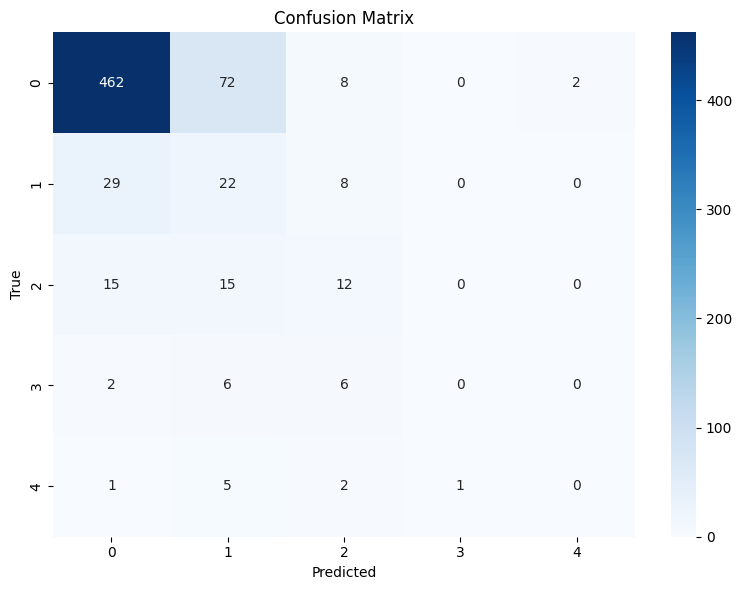


Test AUC (macro-average, OVR): 0.7333


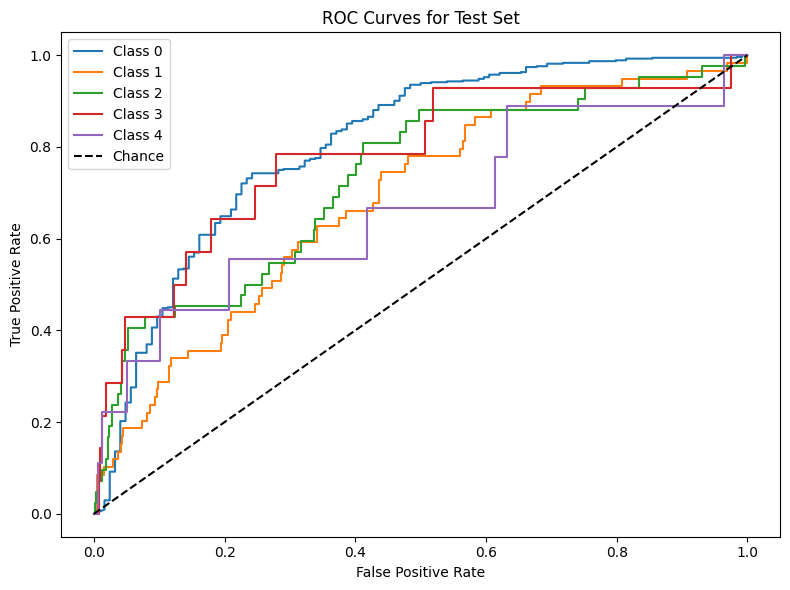

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       455
           1       0.17      0.33      0.23        52
           2       0.22      0.17      0.19        29
           3       0.17      0.10      0.12        10
           4       0.00      0.00      0.00         8

    accuracy                           0.73       554
   macro avg       0.29      0.29      0.28       554
weighted avg       0.77      0.73      0.74       554



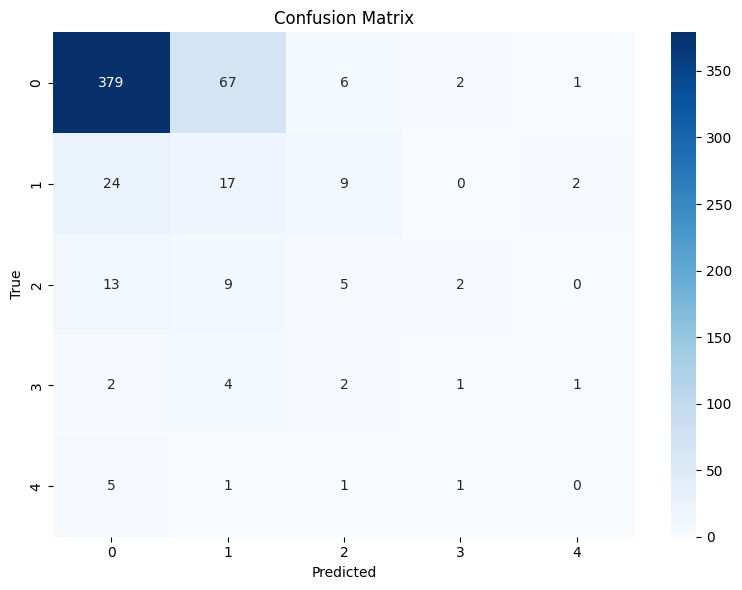


Test AUC (macro-average, OVR): 0.7368


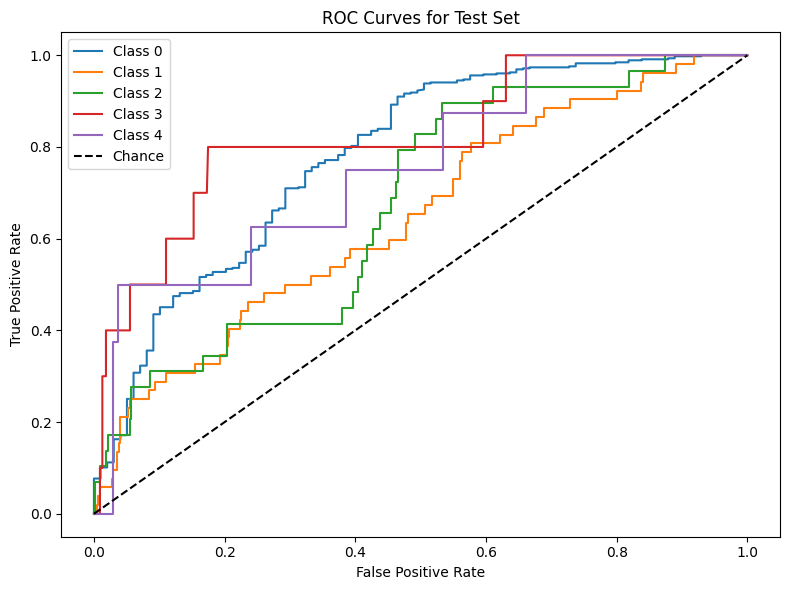

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       395
           1       0.17      0.25      0.20        40
           2       0.23      0.38      0.29        24
           3       0.33      0.10      0.15        10
           4       0.00      0.00      0.00         8

    accuracy                           0.76       477
   macro avg       0.33      0.32      0.31       477
weighted avg       0.79      0.76      0.77       477



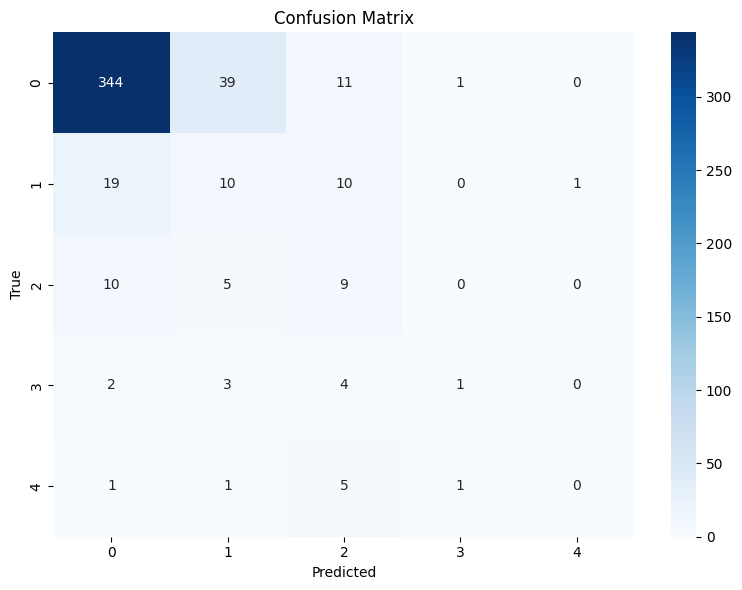


Test AUC (macro-average, OVR): 0.7209


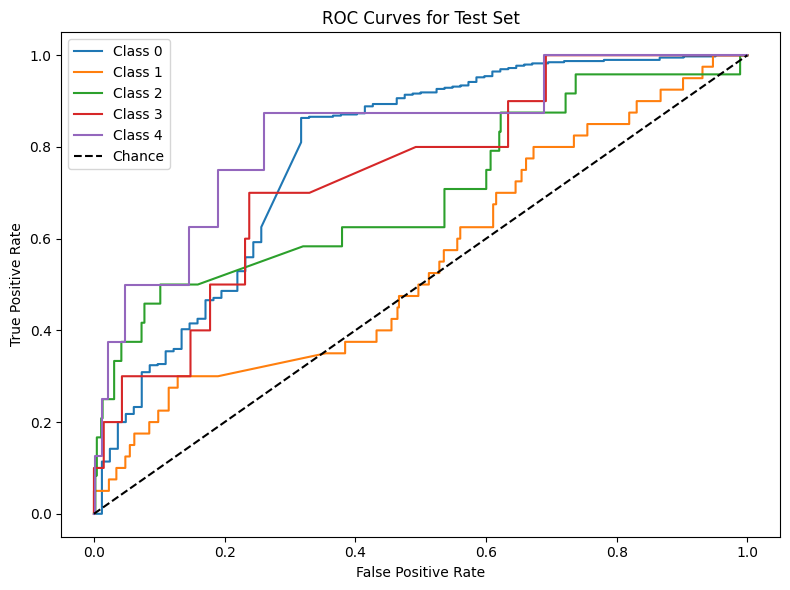

In [7]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Add SMOTE Sample


=== Training Phase 1 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (50, 50), 'alpha': 0.001, 'activation': 'tanh'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77      1785
           1       0.46      0.50      0.48       604
           2       0.30      0.41      0.35       258
           3       0.16      0.42      0.23        59
           4       0.04      0.11      0.06         9

    accuracy                           0.63      2715
   macro avg       0.36      0.43      0.38      2715
weighted avg       0.68      0.63      0.65      2715



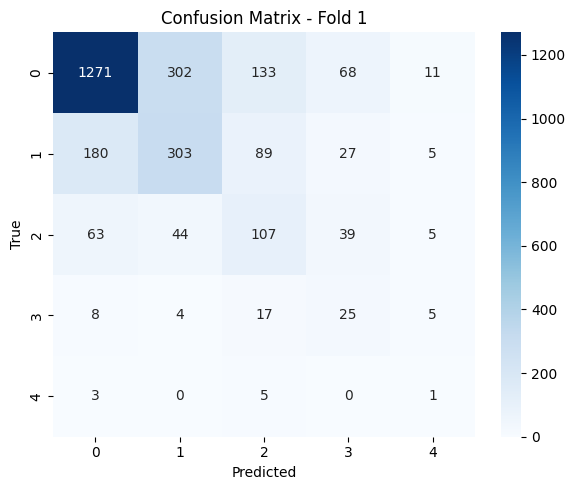

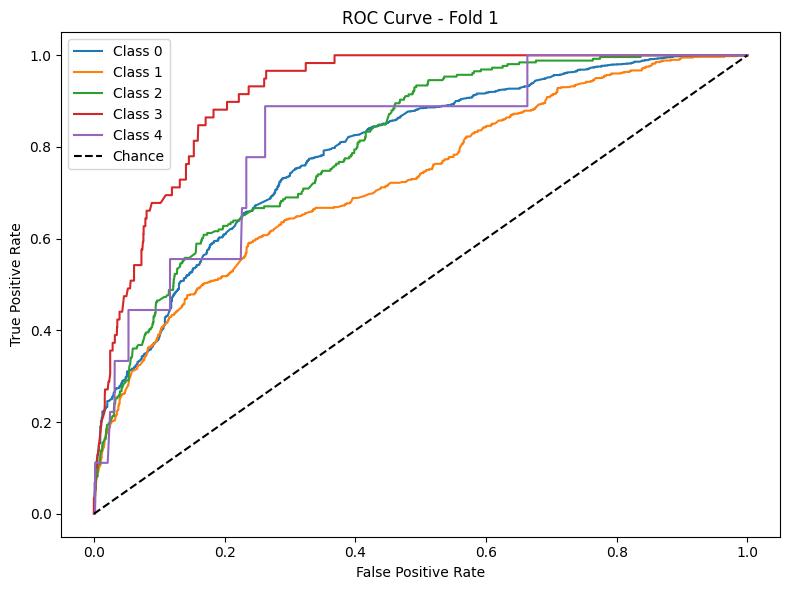


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.61      0.71      1786
           1       0.40      0.55      0.47       603
           2       0.34      0.47      0.39       258
           3       0.19      0.59      0.29        59
           4       0.10      0.50      0.16         8

    accuracy                           0.58      2714
   macro avg       0.37      0.55      0.40      2714
weighted avg       0.68      0.58      0.61      2714



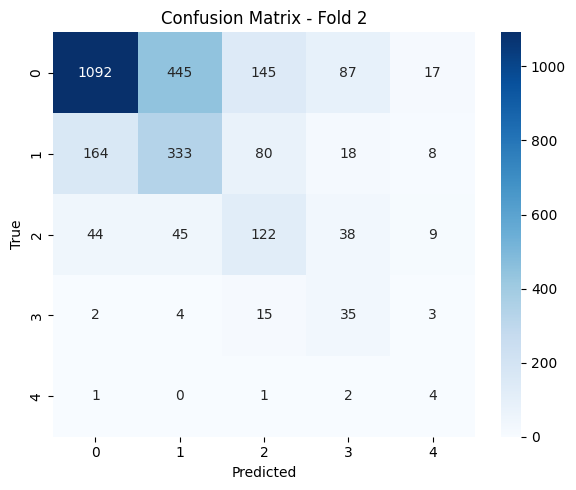

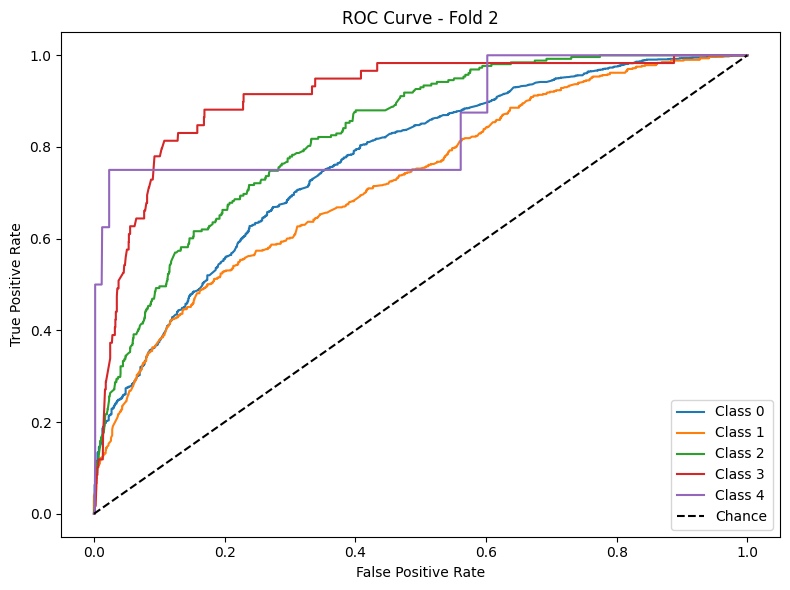

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.68      0.75      1786
           1       0.40      0.49      0.44       603
           2       0.32      0.43      0.37       258
           3       0.20      0.49      0.29        59
           4       0.12      0.38      0.19         8

    accuracy                           0.61      2714
   macro avg       0.38      0.49      0.41      2714
weighted avg       0.67      0.61      0.63      2714



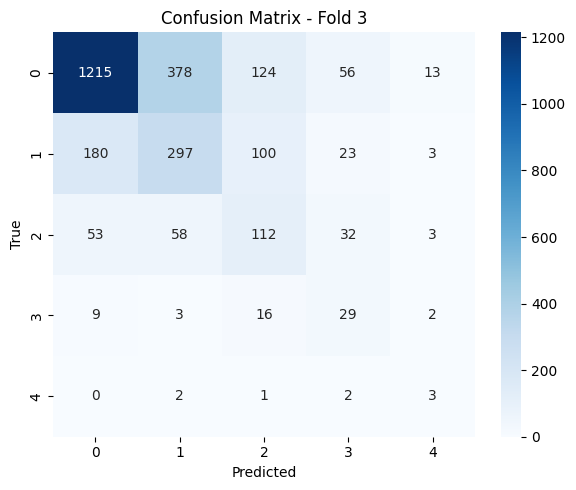

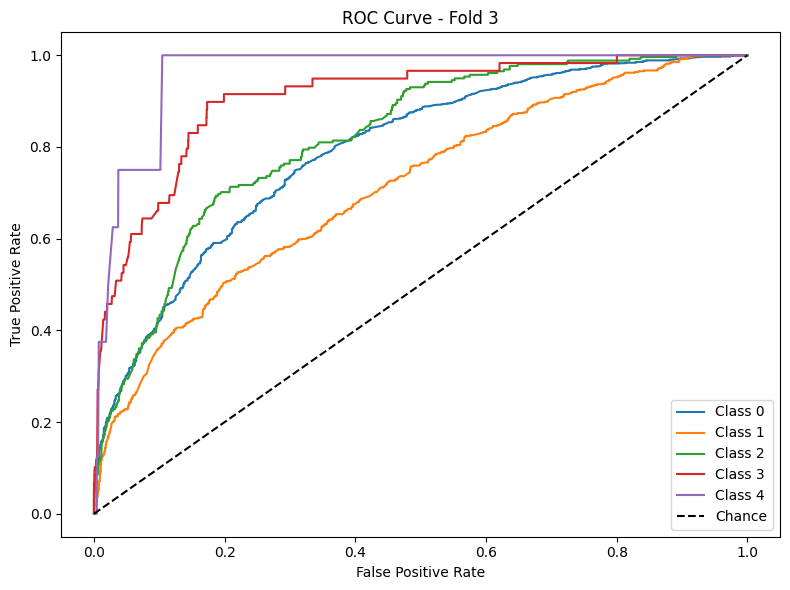


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.73      0.78      1785
           1       0.48      0.53      0.50       603
           2       0.39      0.51      0.44       258
           3       0.19      0.47      0.27        59
           4       0.13      0.22      0.17         9

    accuracy                           0.65      2714
   macro avg       0.40      0.49      0.43      2714
weighted avg       0.70      0.65      0.67      2714



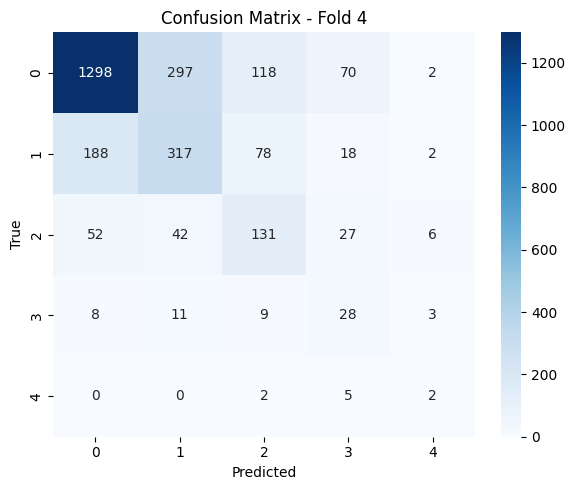

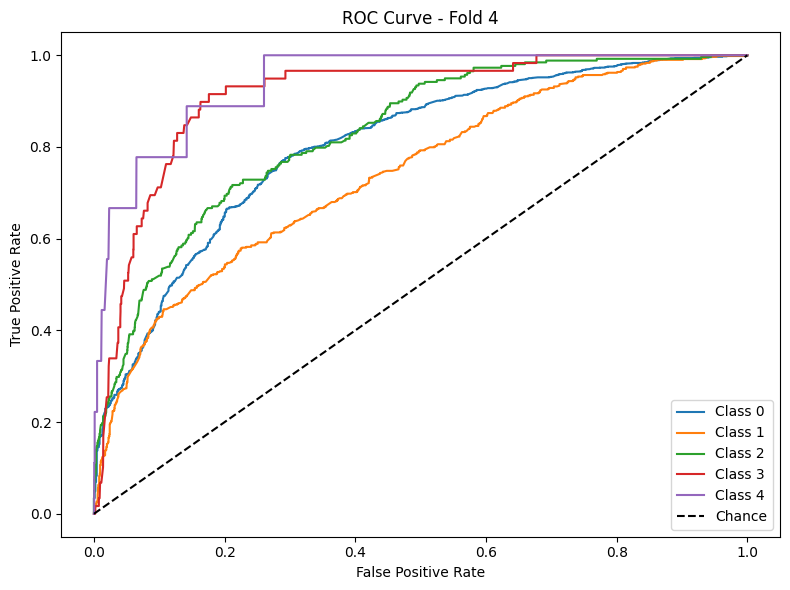

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.79      1785
           1       0.49      0.47      0.48       603
           2       0.34      0.48      0.40       258
           3       0.22      0.47      0.30        59
           4       0.20      0.44      0.28         9

    accuracy                           0.65      2714
   macro avg       0.41      0.52      0.45      2714
weighted avg       0.69      0.65      0.67      2714



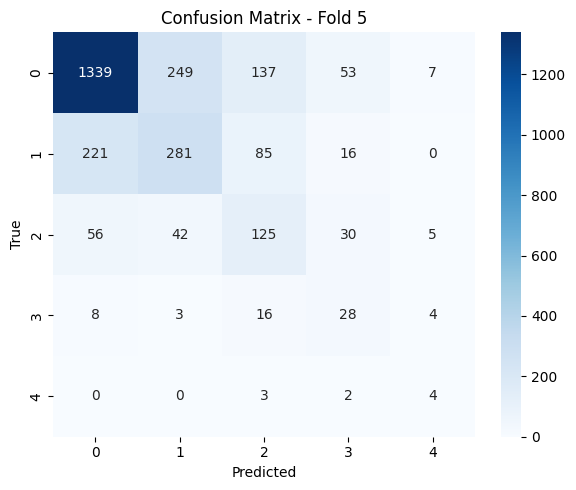

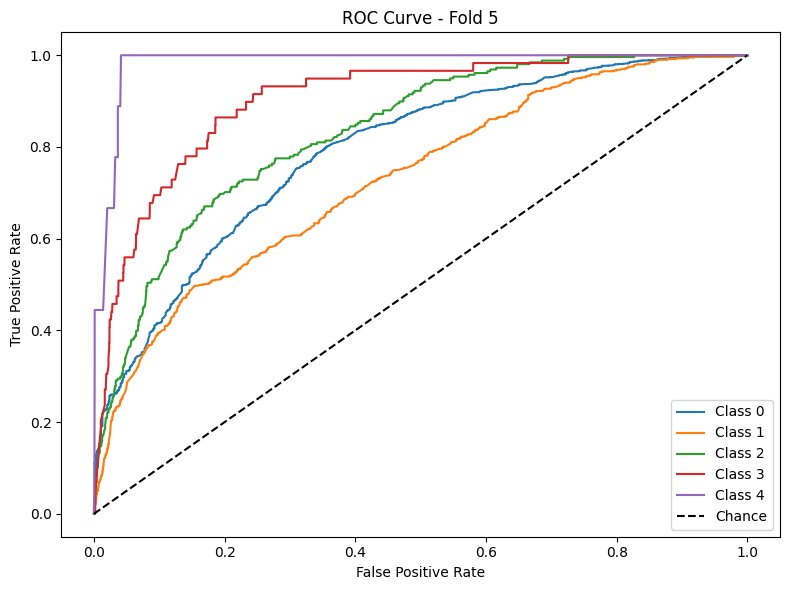


Average Accuracy: 0.6265
Average F1 Macro: 0.4134
Average AUC: 0.8318

=== Training Phase 2 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 200, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'logistic'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.73      0.77      1489
           1       0.40      0.40      0.40       488
           2       0.32      0.40      0.36       220
           3       0.20      0.57      0.30        54
           4       0.09      0.11      0.10         9

    accuracy                           0.62      2260
   macro avg       0.37      0.44      0.39      2260
weighted avg       0.66      0.62      0.64      2260



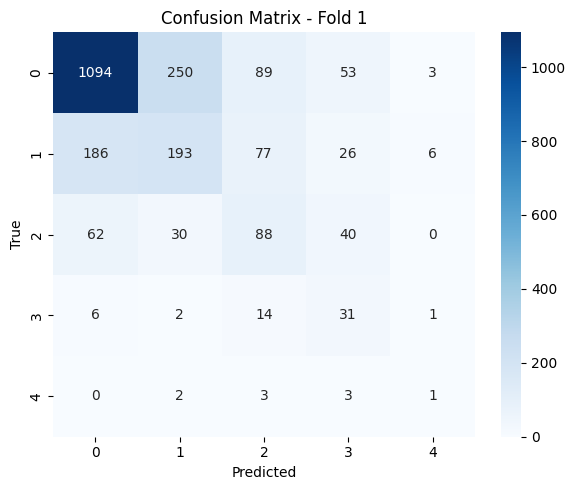

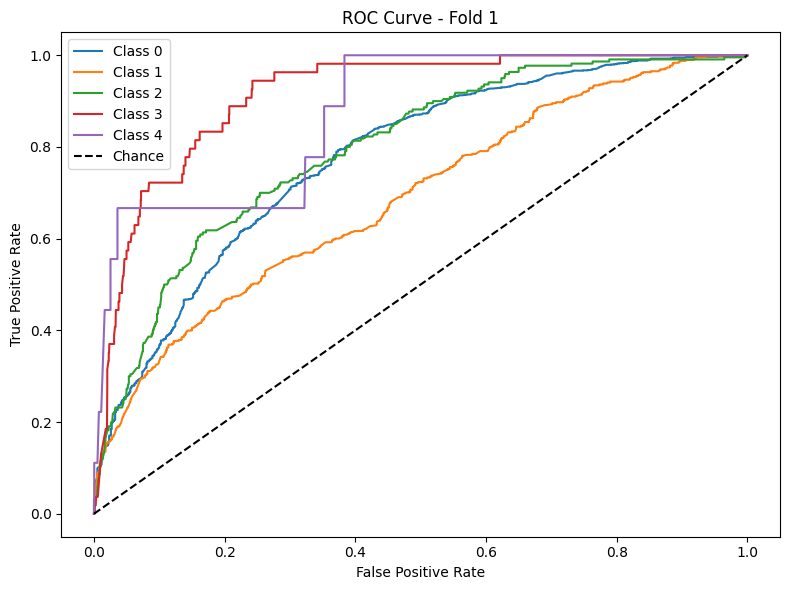


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.71      0.76      1489
           1       0.41      0.51      0.45       489
           2       0.41      0.37      0.39       219
           3       0.21      0.56      0.31        55
           4       0.18      0.38      0.24         8

    accuracy                           0.63      2260
   macro avg       0.40      0.51      0.43      2260
weighted avg       0.67      0.63      0.64      2260



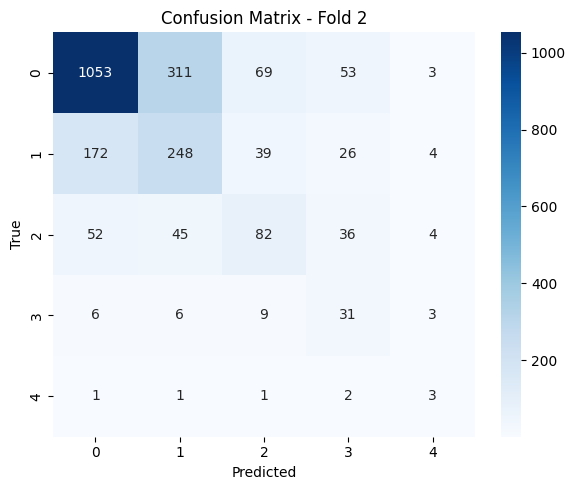

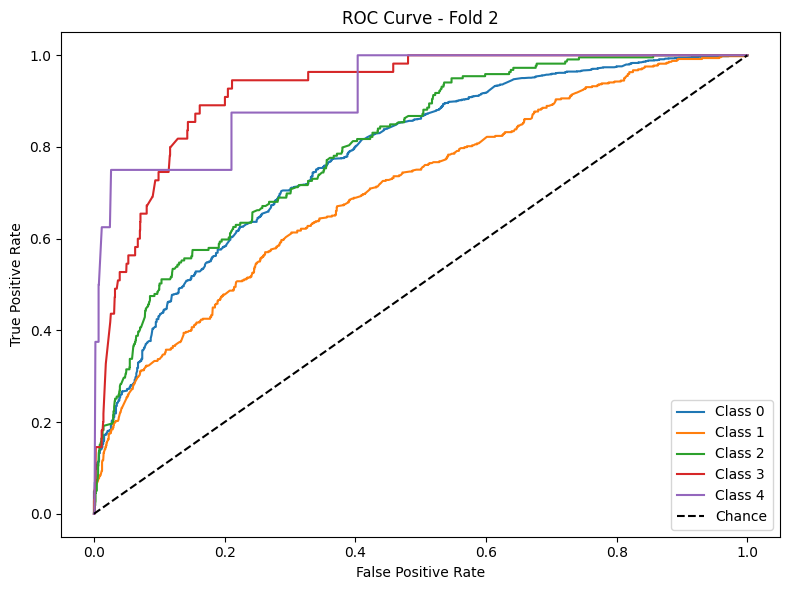


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.67      0.73      1489
           1       0.37      0.38      0.37       489
           2       0.30      0.49      0.37       219
           3       0.14      0.39      0.21        54
           4       0.36      0.50      0.42         8

    accuracy                           0.58      2259
   macro avg       0.40      0.49      0.42      2259
weighted avg       0.65      0.58      0.61      2259



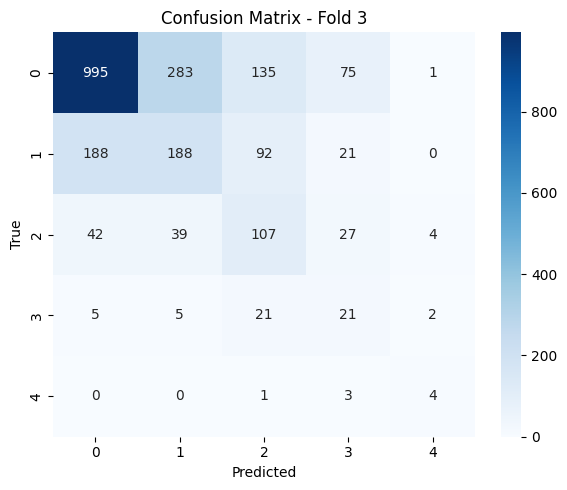

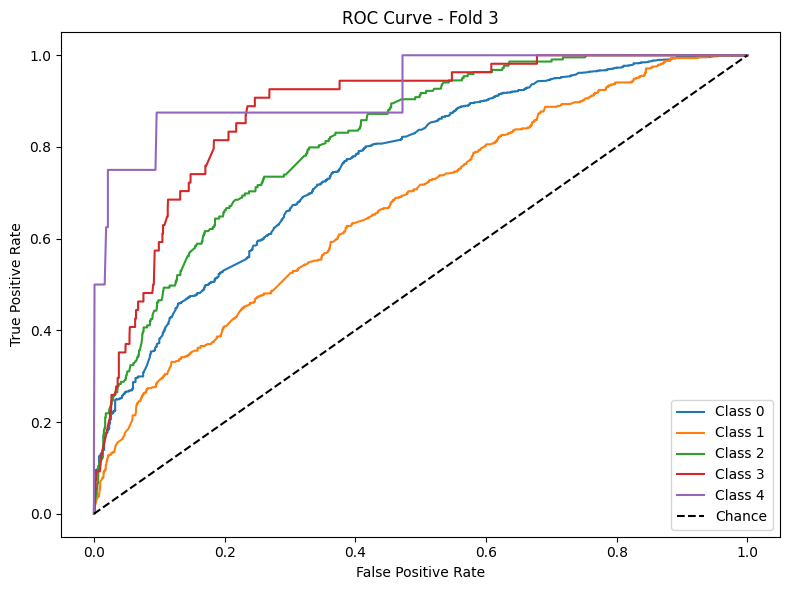


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.69      0.74      1489
           1       0.41      0.46      0.44       489
           2       0.39      0.49      0.43       219
           3       0.23      0.61      0.33        54
           4       0.31      0.50      0.38         8

    accuracy                           0.62      2259
   macro avg       0.43      0.55      0.47      2259
weighted avg       0.67      0.62      0.64      2259



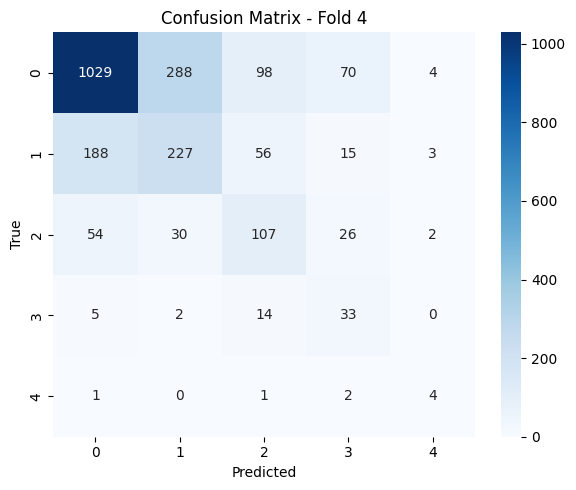

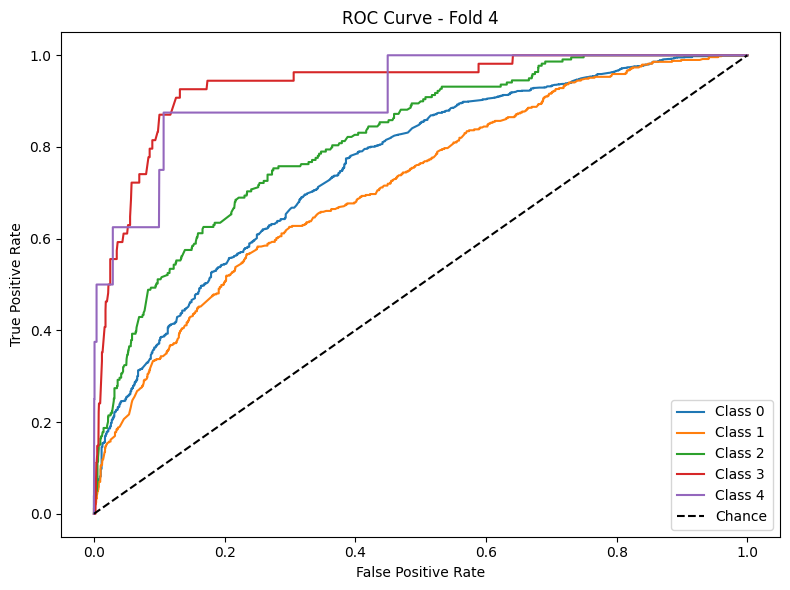


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.75      0.79      1490
           1       0.43      0.39      0.41       488
           2       0.32      0.47      0.38       219
           3       0.18      0.44      0.26        54
           4       0.08      0.25      0.12         8

    accuracy                           0.64      2259
   macro avg       0.37      0.46      0.39      2259
weighted avg       0.68      0.64      0.65      2259



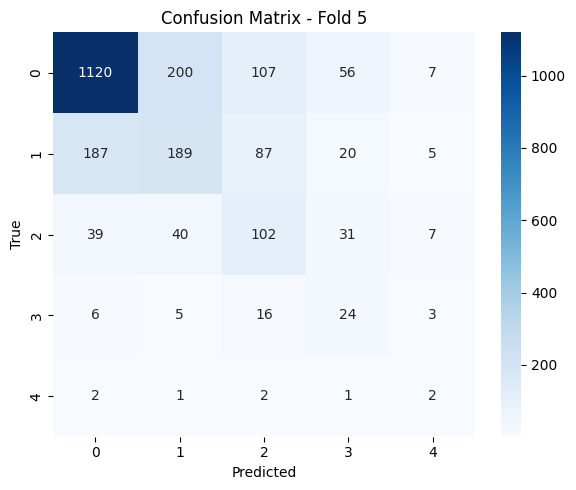

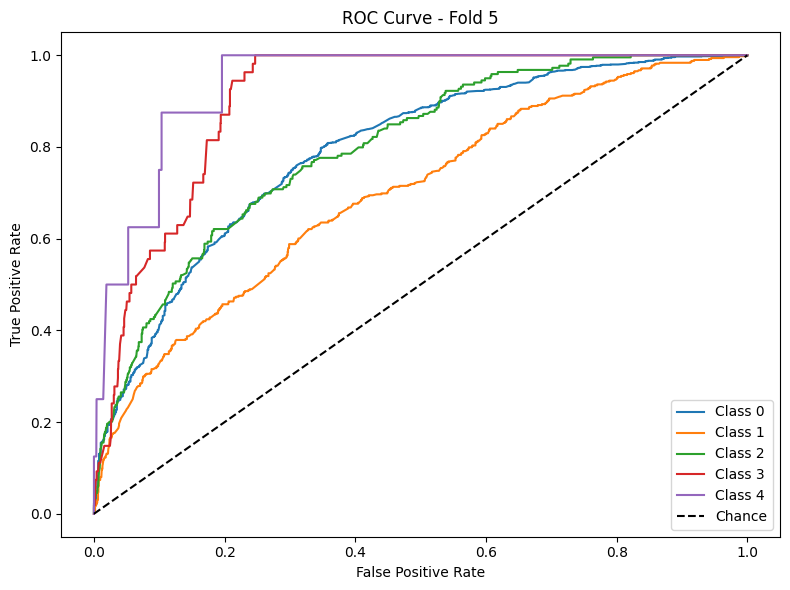


Average Accuracy: 0.6175
Average F1 Macro: 0.4189
Average AUC: 0.8197

=== Training Phase 3 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'logistic'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.72      0.77      1361
           1       0.45      0.44      0.45       459
           2       0.38      0.53      0.44       198
           3       0.18      0.55      0.27        49
           4       0.17      0.29      0.21         7

    accuracy                           0.64      2074
   macro avg       0.40      0.51      0.43      2074
weighted avg       0.69      0.64      0.66      2074



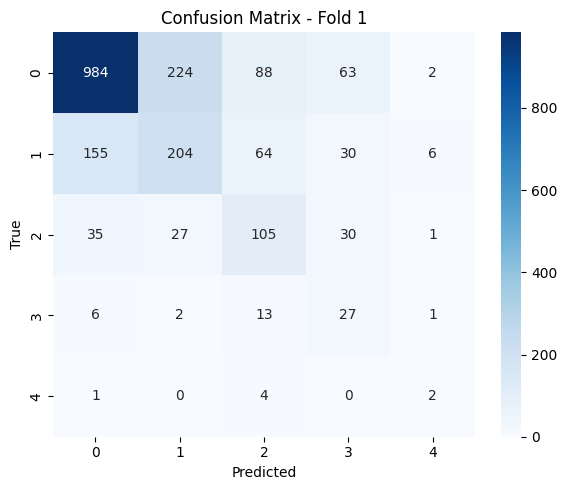

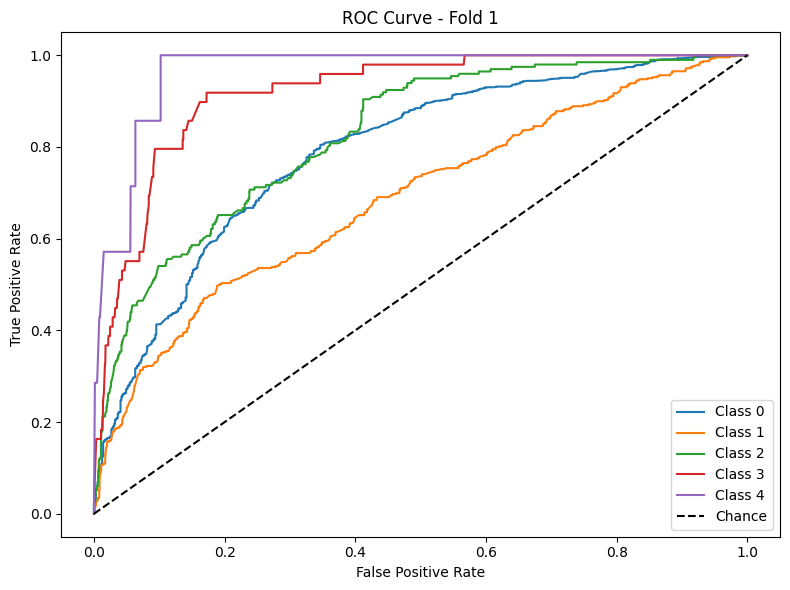


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.72      0.77      1360
           1       0.43      0.45      0.44       459
           2       0.40      0.44      0.42       198
           3       0.20      0.68      0.31        50
           4       0.05      0.29      0.09         7

    accuracy                           0.63      2074
   macro avg       0.38      0.52      0.41      2074
weighted avg       0.69      0.63      0.65      2074



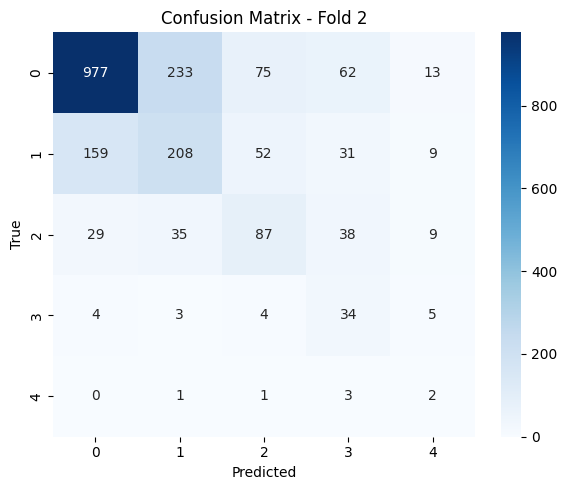

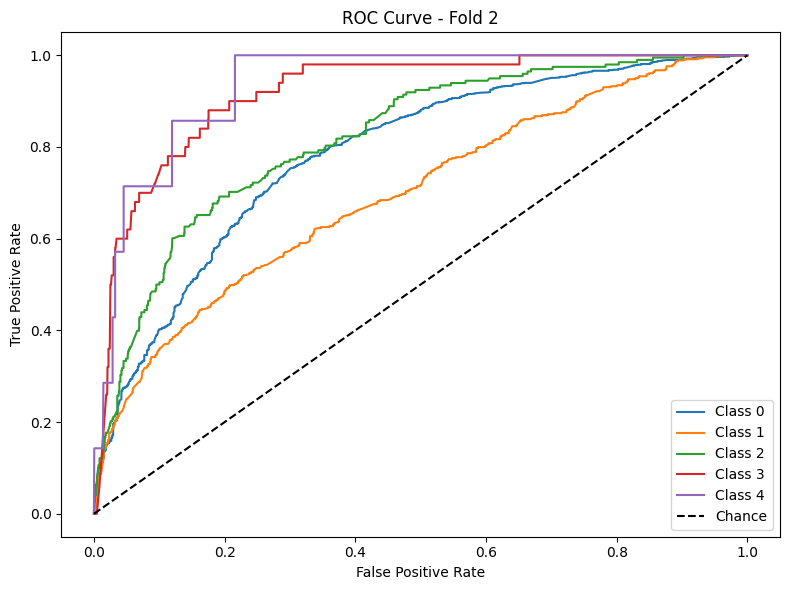


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.71      0.76      1360
           1       0.42      0.46      0.44       459
           2       0.36      0.51      0.42       198
           3       0.21      0.46      0.29        50
           4       0.16      0.43      0.23         7

    accuracy                           0.62      2074
   macro avg       0.39      0.51      0.43      2074
weighted avg       0.67      0.62      0.64      2074



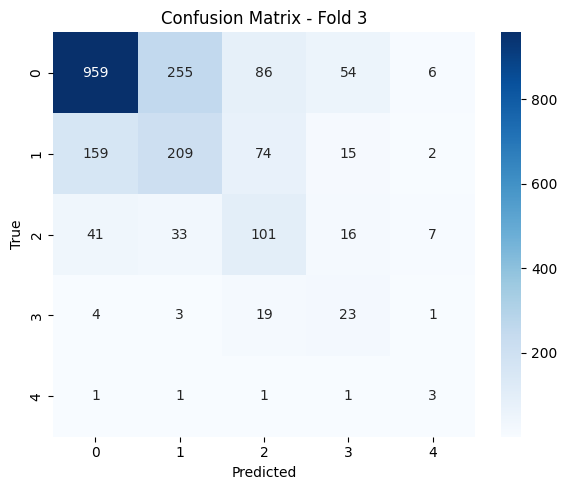

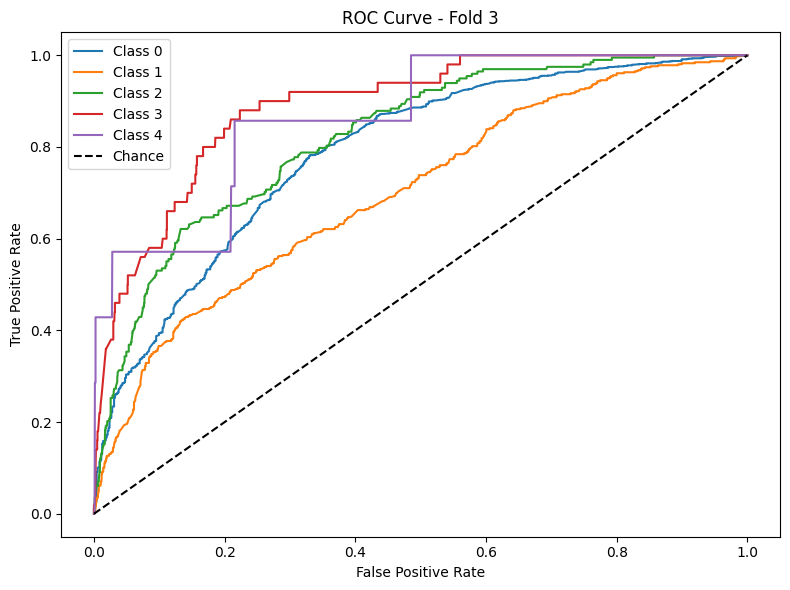


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.71      0.75      1360
           1       0.39      0.43      0.41       459
           2       0.38      0.49      0.43       198
           3       0.28      0.50      0.36        50
           4       0.04      0.14      0.06         7

    accuracy                           0.62      2074
   macro avg       0.38      0.45      0.40      2074
weighted avg       0.66      0.62      0.63      2074



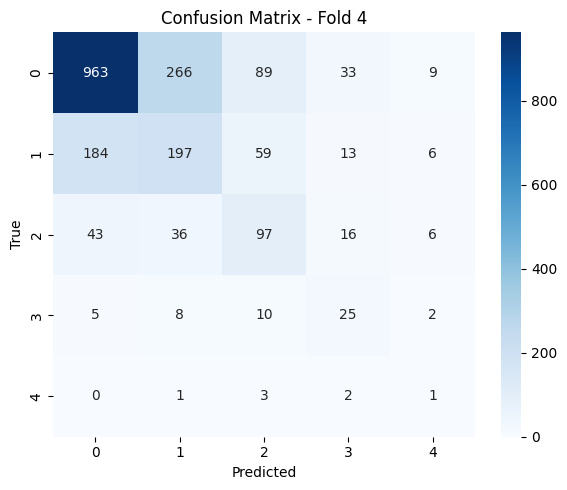

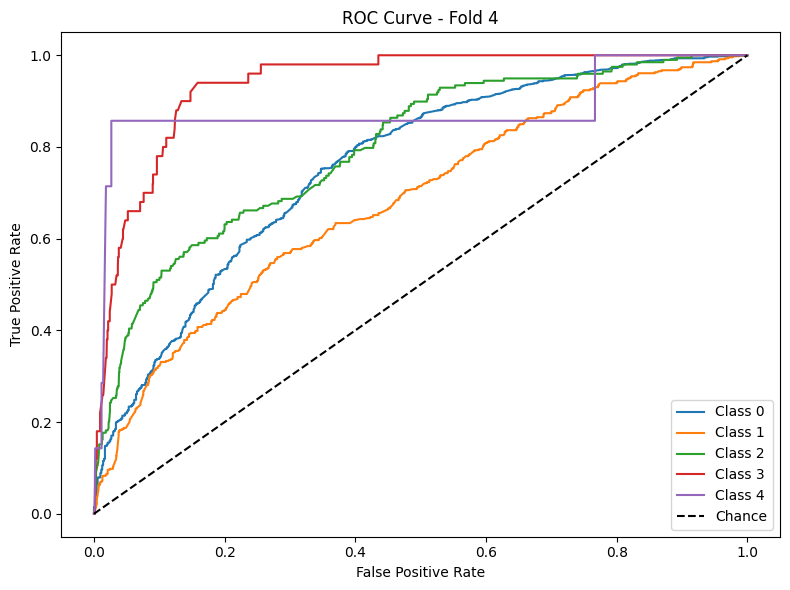

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.69      0.75      1360
           1       0.41      0.51      0.46       460
           2       0.36      0.43      0.39       197
           3       0.20      0.45      0.28        49
           4       0.07      0.14      0.09         7

    accuracy                           0.62      2073
   macro avg       0.37      0.44      0.39      2073
weighted avg       0.67      0.62      0.64      2073



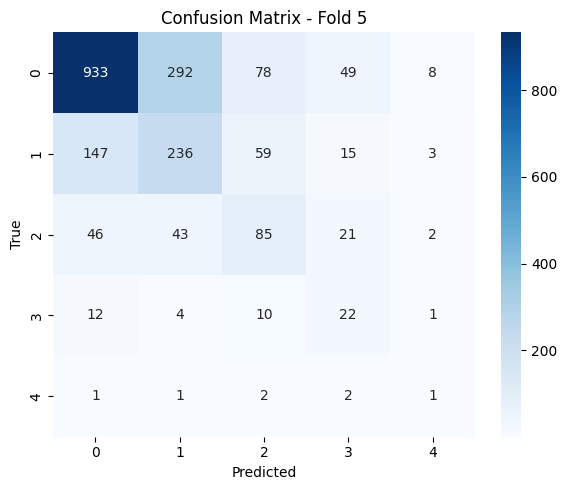

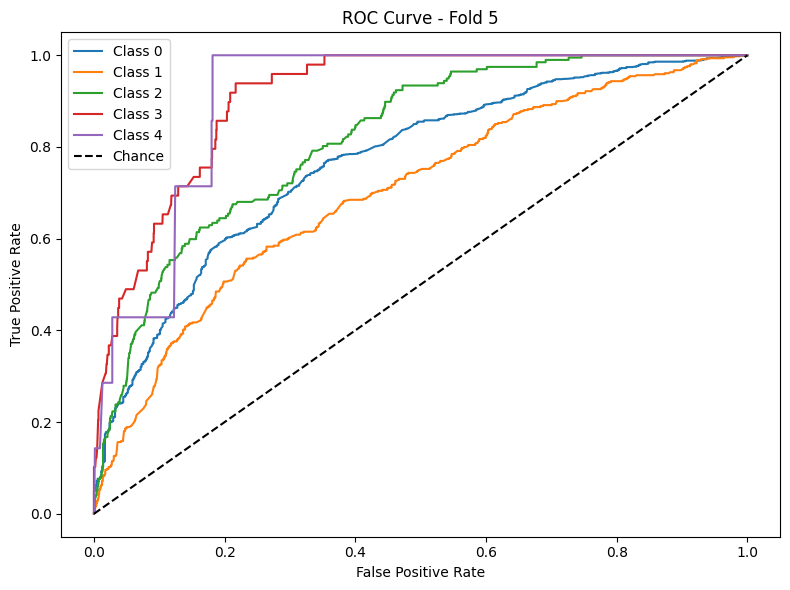


Average Accuracy: 0.6254
Average F1 Macro: 0.4118
Average AUC: 0.8227

=== Training Phase 4 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[Fold 1] Best Parameters Found: {'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (50, 50), 'alpha': 0.0001, 'activation': 'tanh'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.69      0.74      1000
           1       0.43      0.51      0.47       355
           2       0.37      0.42      0.40       139
           3       0.23      0.46      0.31        39
           4       0.14      0.67      0.23         6

    accuracy                           0.62      1539
   macro avg       0.40      0.55      0.43      1539
weighted avg       0.66      0.62      0.63      1539



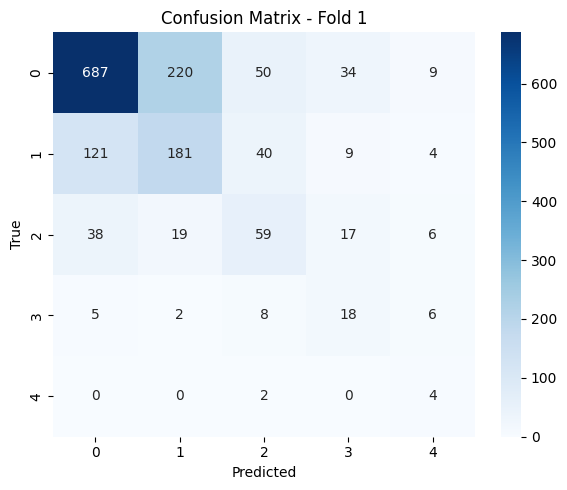

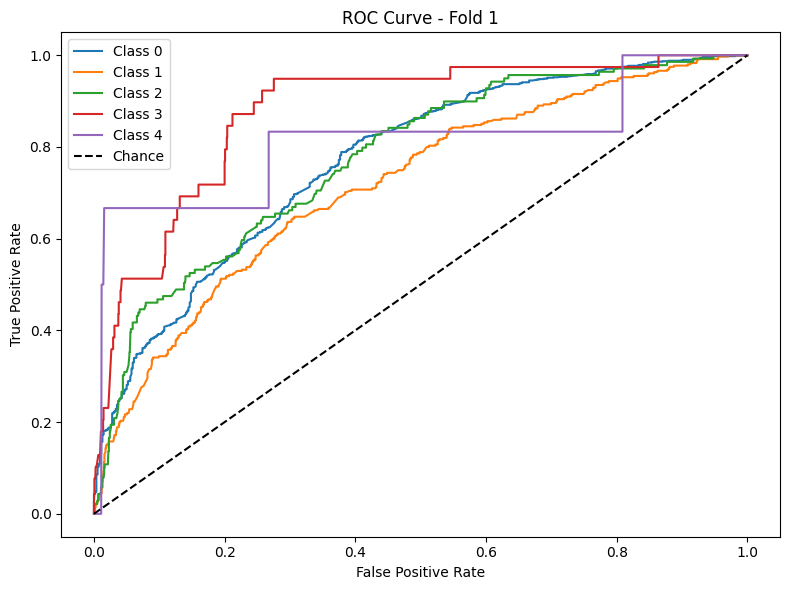


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.72      0.75      1000
           1       0.44      0.49      0.46       355
           2       0.44      0.45      0.45       139
           3       0.21      0.45      0.28        40
           4       0.00      0.00      0.00         5

    accuracy                           0.63      1539
   macro avg       0.38      0.42      0.39      1539
weighted avg       0.67      0.63      0.65      1539



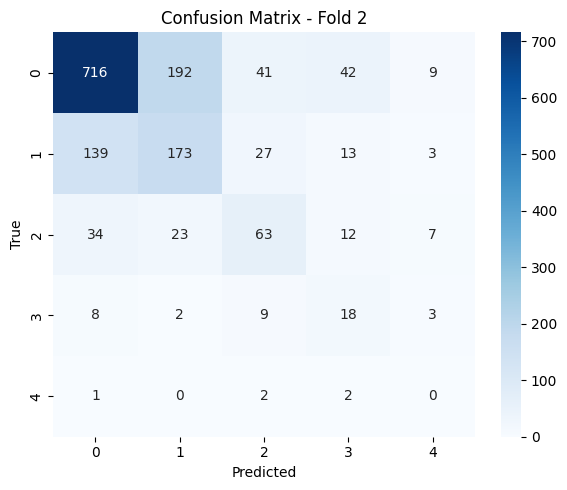

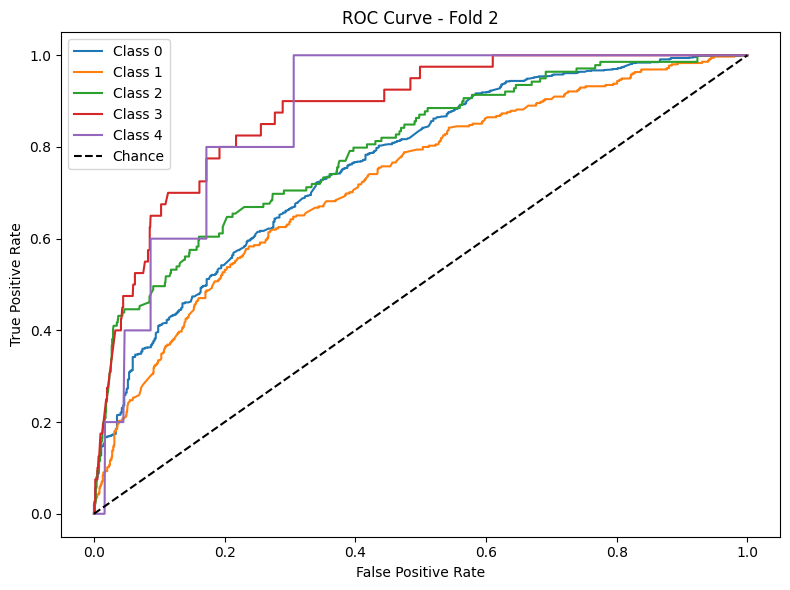


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.66      0.73       999
           1       0.42      0.56      0.48       355
           2       0.35      0.44      0.39       139
           3       0.28      0.50      0.36        40
           4       0.12      0.33      0.18         6

    accuracy                           0.61      1539
   macro avg       0.40      0.50      0.43      1539
weighted avg       0.67      0.61      0.63      1539



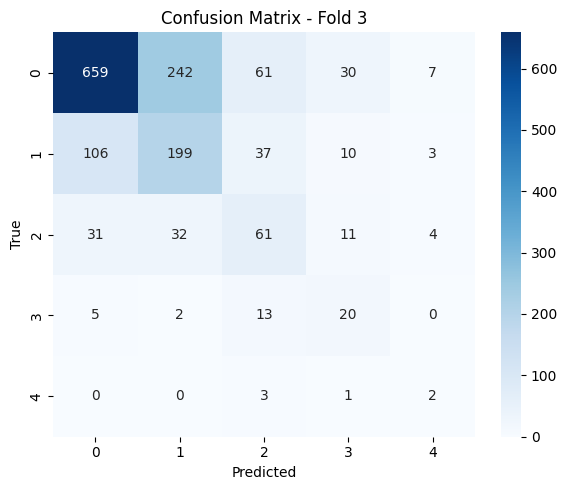

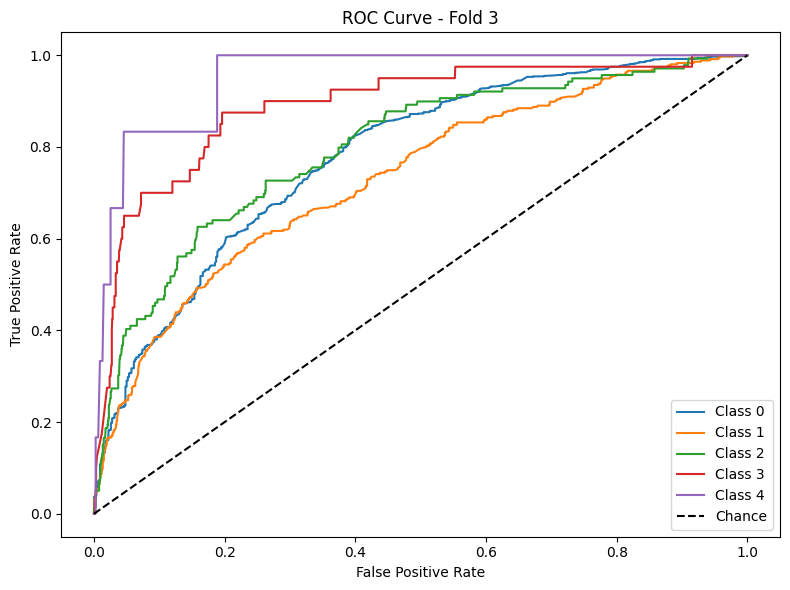


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.78       999
           1       0.48      0.42      0.44       356
           2       0.32      0.47      0.38       138
           3       0.24      0.56      0.34        39
           4       0.18      0.67      0.29         6

    accuracy                           0.64      1538
   macro avg       0.41      0.57      0.45      1538
weighted avg       0.68      0.64      0.65      1538



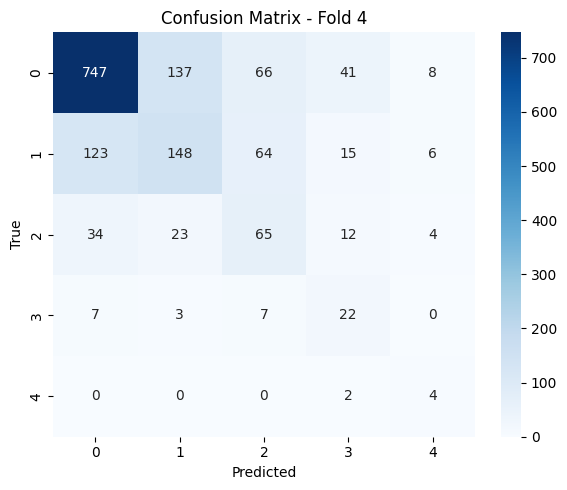

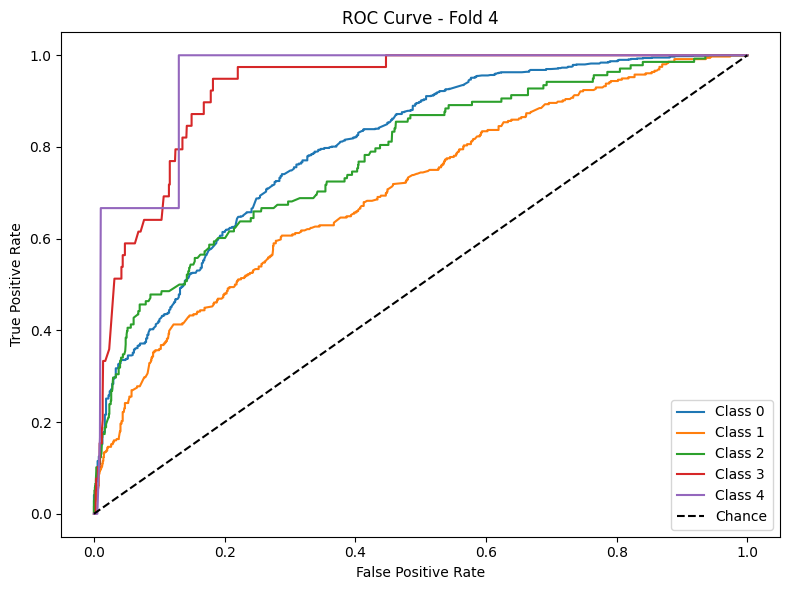


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.65      0.73       999
           1       0.41      0.57      0.48       356
           2       0.36      0.43      0.39       138
           3       0.34      0.67      0.45        39
           4       0.00      0.00      0.00         6

    accuracy                           0.61      1538
   macro avg       0.39      0.46      0.41      1538
weighted avg       0.67      0.61      0.63      1538



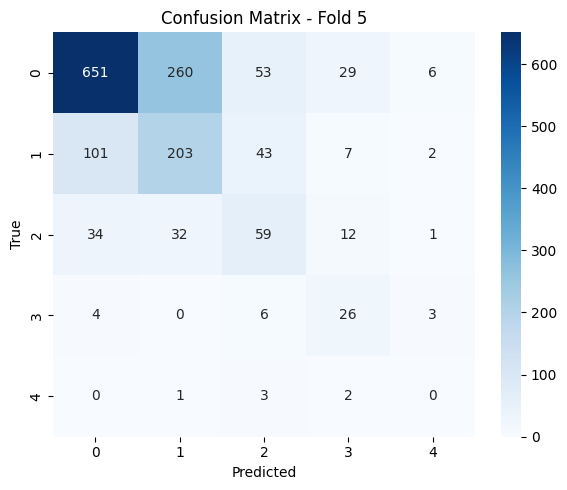

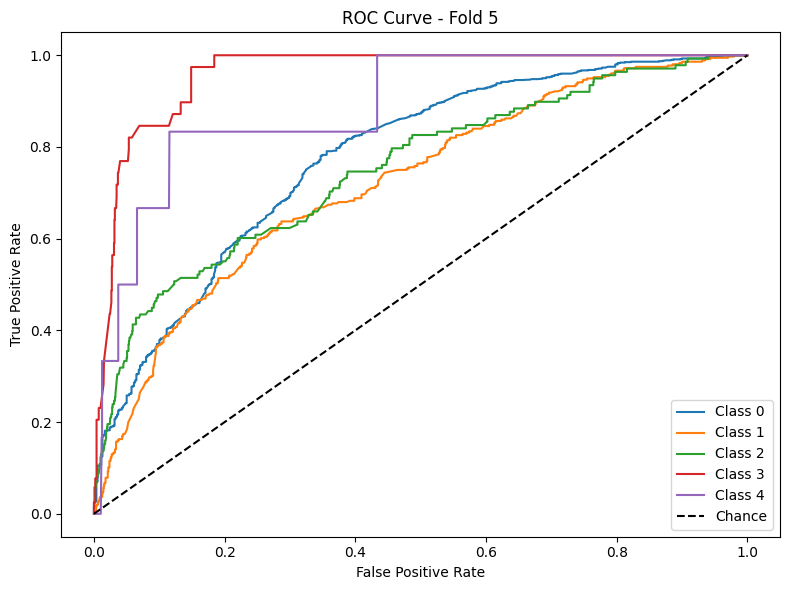


Average Accuracy: 0.6220
Average F1 Macro: 0.4203
Average AUC: 0.8159


In [8]:
phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics



Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       568
           1       0.15      0.29      0.20        63
           2       0.18      0.14      0.16        43
           3       0.12      0.13      0.13        15
           4       0.00      0.00      0.00         9

    accuracy                           0.71       698
   macro avg       0.27      0.28      0.27       698
weighted avg       0.75      0.71      0.73       698



/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.1

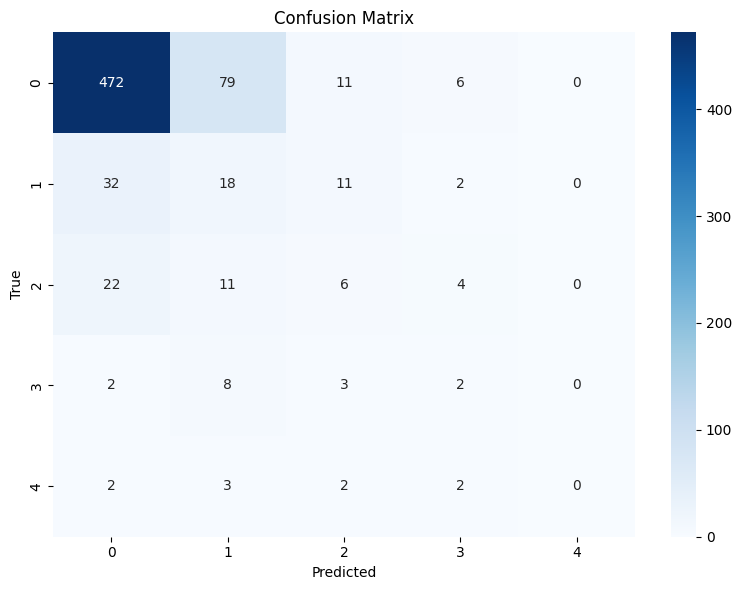


Test AUC (macro-average, OVR): 0.6342


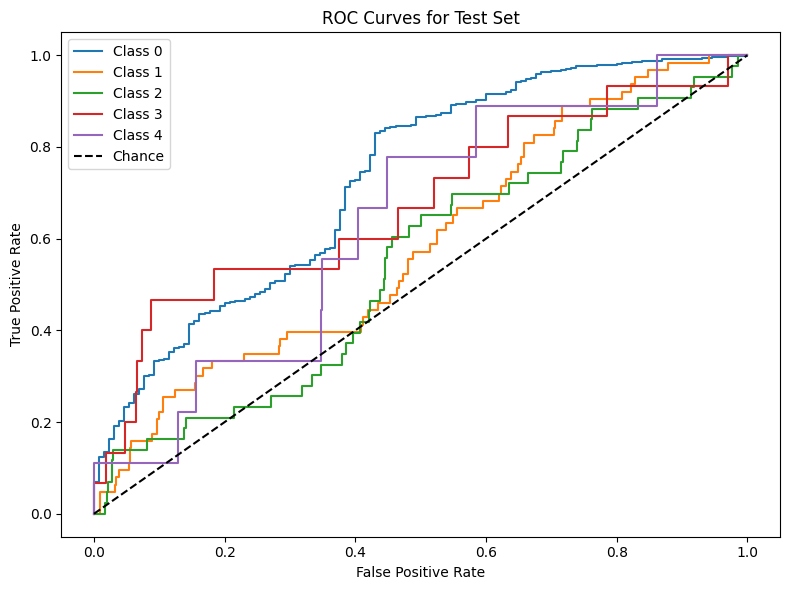

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.62      0.72       544
           1       0.08      0.31      0.12        59
           2       0.29      0.26      0.28        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.55       668
   macro avg       0.24      0.24      0.22       668
weighted avg       0.72      0.55      0.61       668



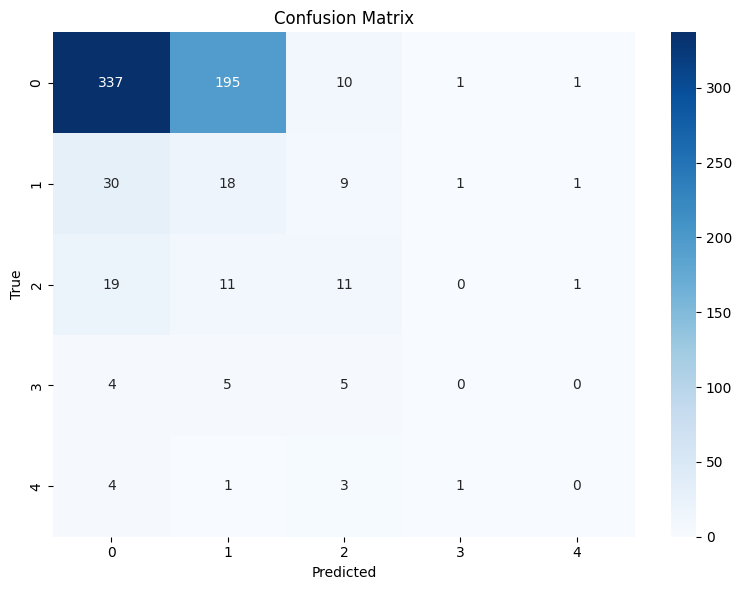


Test AUC (macro-average, OVR): 0.6896


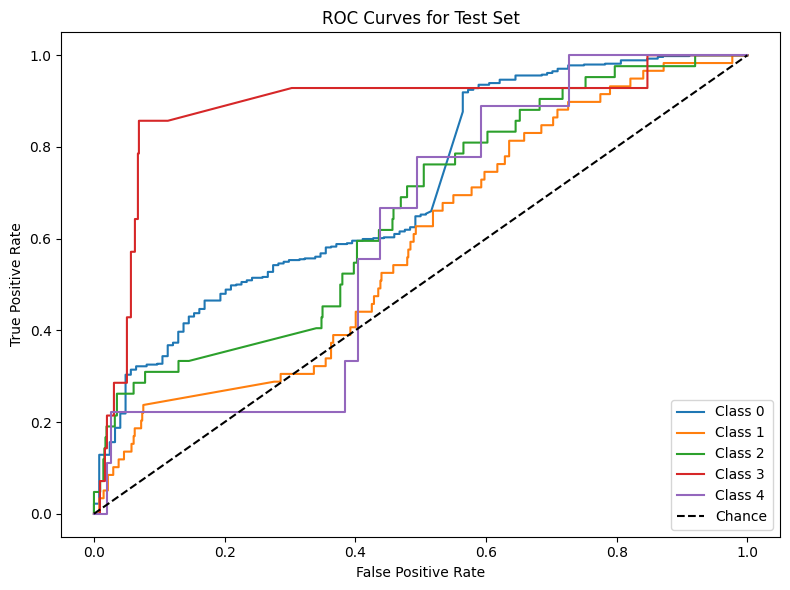

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.1


Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.77      0.83       455
           1       0.15      0.33      0.20        52
           2       0.17      0.21      0.19        29
           3       0.15      0.20      0.17        10
           4       0.00      0.00      0.00         8

    accuracy                           0.68       554
   macro avg       0.27      0.30      0.28       554
weighted avg       0.76      0.68      0.71       554



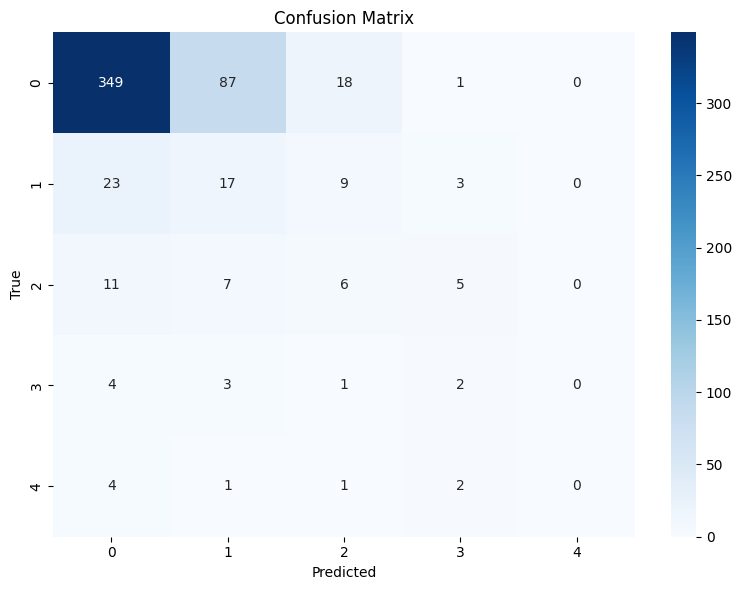


Test AUC (macro-average, OVR): 0.6902


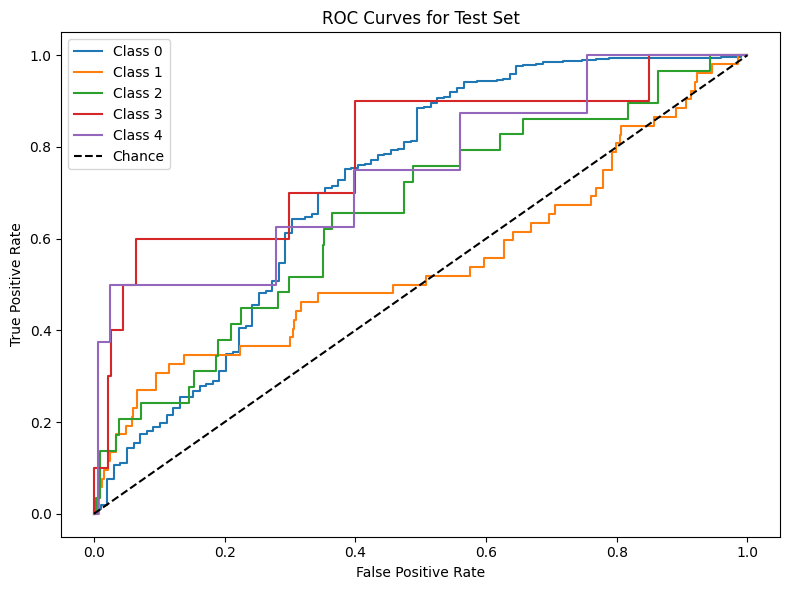

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.56      0.69       395
           1       0.11      0.17      0.14        40
           2       0.06      0.29      0.10        24
           3       0.17      0.20      0.18        10
           4       0.08      0.38      0.13         8

    accuracy                           0.50       477
   macro avg       0.26      0.32      0.25       477
weighted avg       0.77      0.50      0.60       477



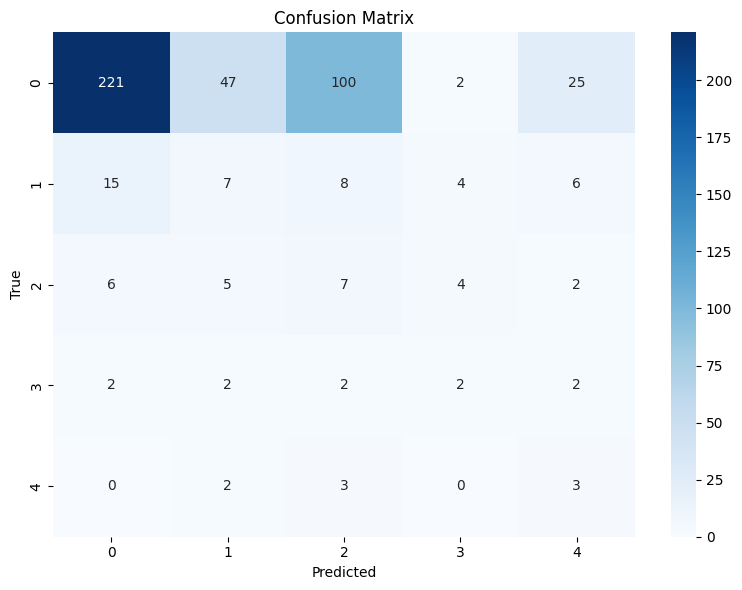


Test AUC (macro-average, OVR): 0.6789


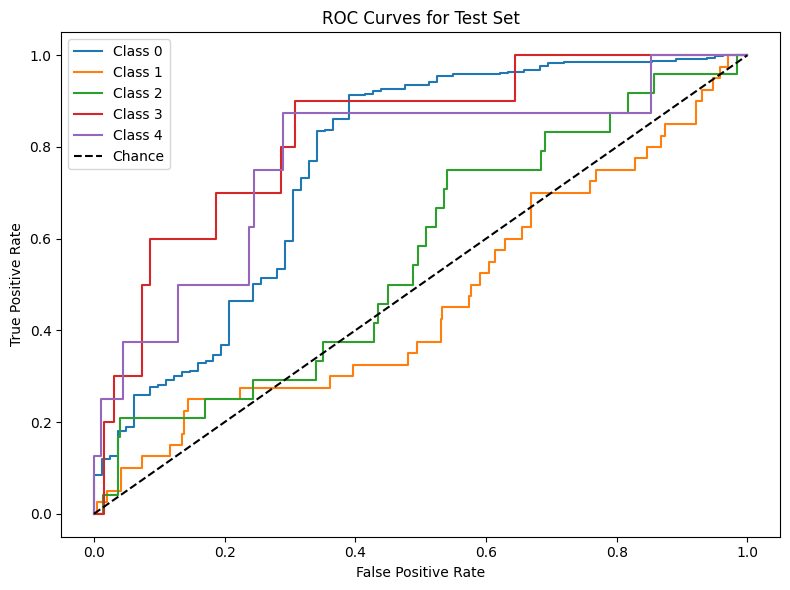

In [9]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)
